# Title:
* Project title - Bank marketing
* Name - Alexandr Belykh
* Group - IT3-2209
* Date - 09.12.2025

# Introduction

### Ultimate goal of the project
1) To find potential clients that will subscribe to deposit
2) Find as many target-client as possible
3) Ensure that business loss is minimized

### Purpose of the project:
* Research and work with financial/bank data
* To find clients that most likely will take a deposit
* Perform EDA to explore and clean data
* Apply ML methods to solve the task

# Data Description

* Data source: https://archive.ics.uci.edu/dataset/222/bank+marketing
* Dataset size: 16 features and 45211 observations
* Missing values in columns 'contact', 'pdays', 'poutcome'
* Disbalance in target

### Description of variables

| Variable | Type | Description |
|---------|------|-------------|
| age | numeric (int) | Client’s age. |
| job | categorical | Type of client’s profession (e.g., admin., technician, blue-collar, student, retired). |
| marital | categorical | Marital status (single, married, divorced). |
| education | categorical | Education level (primary, secondary, tertiary, unknown). |
| default | binary (yes/no) | Whether the client has credit default. Rare and mostly “no”. |
| balance | numeric (int) | Average yearly account balance. Can be negative (debts). Highly skewed. |
| housing | binary (yes/no) | Whether the client has a housing loan. |
| loan | binary (yes/no) | Whether the client has a personal loan. |
| contact | categorical | Contact communication type (cellular, telephone, unknown). |
| day | numeric (int 1–31) | Day of the month when the contact was performed. |
| month | categorical | Month of the last contact (jan–dec). |
| duration | numeric (int, seconds) | Duration of the last contact. Strongly predictive but risky for leakage. |
| campaign | numeric (int) | Number of contacts performed during this campaign for this client (including last call). |
| pdays | numeric (int) | Days passed since last contact from previous campaign (-1 means no prior contact). |
| previous | numeric (int) | Number of contacts before this campaign. |
| poutcome | categorical | Outcome of previous marketing campaign (success, failure, other, unknown). |
| y (target) | binary (yes/no) | Whether the client subscribed to a term deposit. |


# Data exploring and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from imblearn.over_sampling import SMOTE


In [2]:
from pathlib import Path

Path('figures').mkdir(exist_ok=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_bank = pd.read_csv('bank-full.csv', sep=';')

In [5]:
df_bank.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [6]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df_bank.shape

(45211, 17)

In [12]:
for col in df_bank.columns:
    if df_bank[col].dtype == 'object':
        print(f'-- {col} ({df_bank[col].nunique()} unique)')
        print(df_bank[col].value_counts(dropna=False).head(10))
        print()

-- job (12 unique)
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
Name: count, dtype: int64

-- marital (3 unique)
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

-- education (4 unique)
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

-- default (2 unique)
default
no     44396
yes      815
Name: count, dtype: int64

-- housing (2 unique)
housing
yes    25130
no     20081
Name: count, dtype: int64

-- loan (2 unique)
loan
no     37967
yes     7244
Name: count, dtype: int64

-- contact (3 unique)
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

-- month (12 unique)
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan    

In [8]:
df_bank.contact.value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

In [9]:
df_bank.poutcome.value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [10]:
df_bank[df_bank.pdays < 0].count()

age          36954
job          36954
marital      36954
education    36954
default      36954
balance      36954
housing      36954
loan         36954
contact      36954
day          36954
month        36954
duration     36954
campaign     36954
pdays        36954
previous     36954
poutcome     36954
y            36954
dtype: int64

In [11]:
df_bank.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

### Initial observations
1) We see, that in 3 columns there are missed value, but alreday imputed with 'unknown' values or -1
2) Target is unbalanced

## Cleaning & Preparation

In [13]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### There is no missing values in direct meaning, but we see, that such columns as "education" and "contact" has many unknown values and pdays has issues with -1 number

In [14]:
for col in df_bank.select_dtypes(include=['object']).columns:
    if (df_bank[col] == 'unknown').sum() > 0:
        print(col, ':', (df_bank[col] == 'unknown').sum())

job : 288
education : 1857
contact : 13020
poutcome : 36959


#### Unique pdays values

In [17]:
df_bank['pdays'].unique()[:10]


array([ -1, 151, 166,  91,  86, 143, 147,  89, 140, 176], dtype=int64)

#### Check for duplicates

In [18]:
df_bank.duplicated().sum()

0

## Conclusion for cleaning & preparation

I do not think it is is useful to impute the columns with "unknown" values because
* job - means there is just no data and this is not "unemployed" as there is different category for that
* education - there is no point in rename "unknown category" and this, again, shows just missing values
* contact - it again shows just error (missing) in original data and there will not be problem for ML

But pdays is much more interesting and we can consider -1 as Nan as it is no more than absense of contact with clients, I will impute them as "no_previous", but as it is numerical value I will put it in different column and initial problem will replace with 0 which literally means that clients didn't have previous contact



In [19]:
df_clean = df_bank.copy()

df_clean['no_prev_contact'] = (df_clean['pdays'] == -1).astype(int) # first!

df_clean['pdays'] = df_clean['pdays'].replace(-1, 0)

In [20]:
df_clean.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no_prev_contact
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,no,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,no,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,no,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,no,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,no,1
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,0,0,unknown,no,1
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,0,0,unknown,no,1
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,0,0,unknown,no,1
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,0,0,unknown,no,1
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,0,0,unknown,no,1


I will handle outliers and do encoding after EDA part

# Exploratory Statistical Analysis

First, determine numerical and categorical columns (exclude target 'y')

In [21]:
target_col = 'y'
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
if target_col in cat_cols:
    cat_cols.remove(target_col)

print(f"Numeric cols ({len(num_cols)}): {num_cols}")
print(f"Categorical cols ({len(cat_cols)}): {cat_cols}")

Numeric cols (8): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'no_prev_contact']
Categorical cols (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## I will make some plots to see the distribution of data and descriptive statistics:
* Histogram + KDE
* boxplot
* Q-Q plot
* log transformation (if appliable)

## Also some other statistics descriptions:

* Skew (distribution asymmetry) - Indicates how skewed the distribution is to the left or right.
    * Skew ≈ 0 → symmetrical distribution
    * Skew > 0 → long tail to the right
    * Skew < 0 → long tail to the left

* Kurtosis (distribution steepness/heavy tails) - indicates the extent to which the distribution has "heavy tails" and high peaks.
    * Kurtosis = 0 (normal distribution)
    * Kurtosis > 0 → heavier tails (many extreme values)
    * Kurtosis < 0 → light tails, flatter distribution


Column: age
       count      mean        std   min    1%    5%   10%   25%   50%   75%  \
age  45211.0  40.93621  10.618762  18.0  23.0  27.0  29.0  33.0  39.0  48.0   

      90%   95%   99%   max  
age  56.0  59.0  71.0  95.0  
skew: 0.6848179257252598 kurtosis: 0.3195703759105042


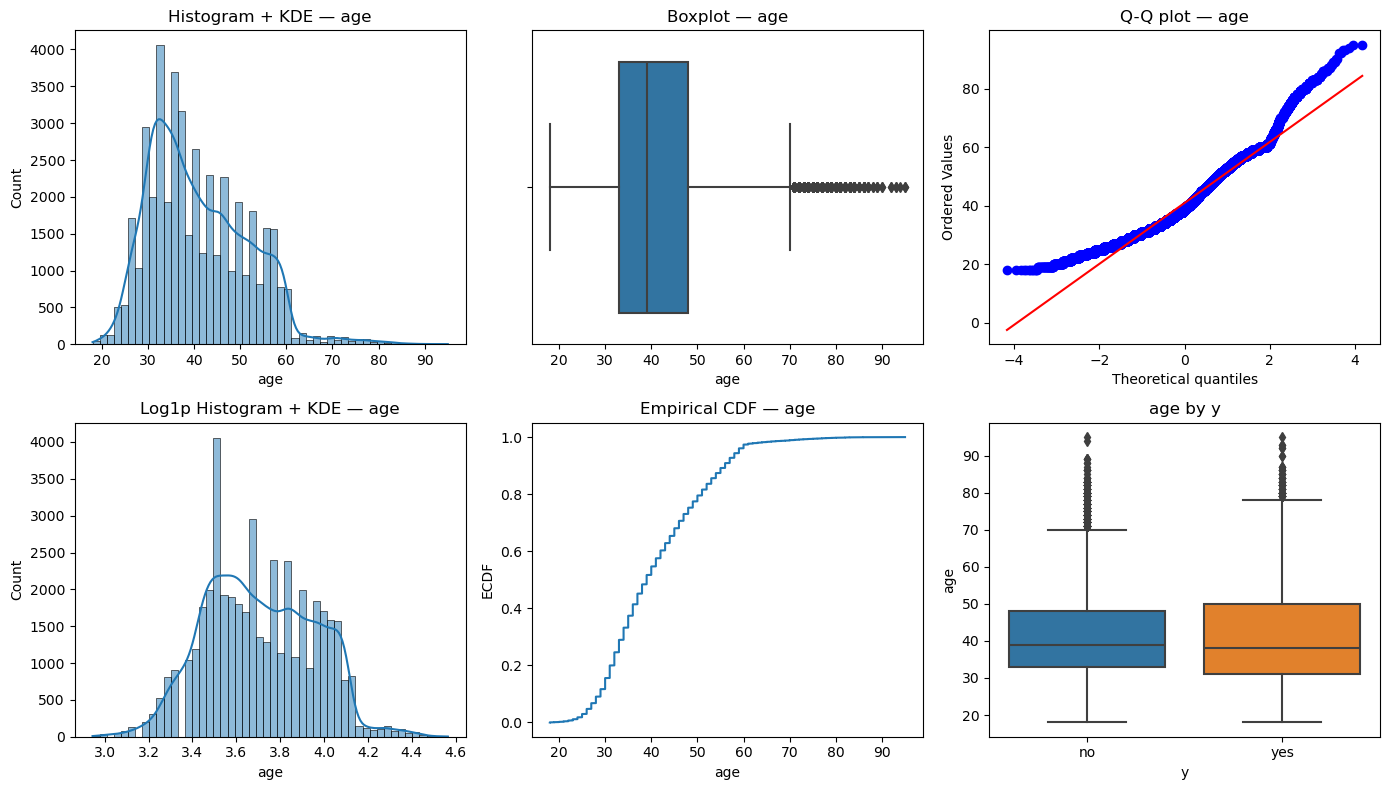


Column: balance
           count         mean          std     min     1%     5%  10%   25%  \
balance  45211.0  1362.272058  3044.765829 -8019.0 -627.0 -172.0  0.0  72.0   

           50%     75%     90%     95%      99%       max  
balance  448.0  1428.0  3574.0  5768.0  13164.9  102127.0  
skew: 8.360308326166326 kurtosis: 140.75154662504158


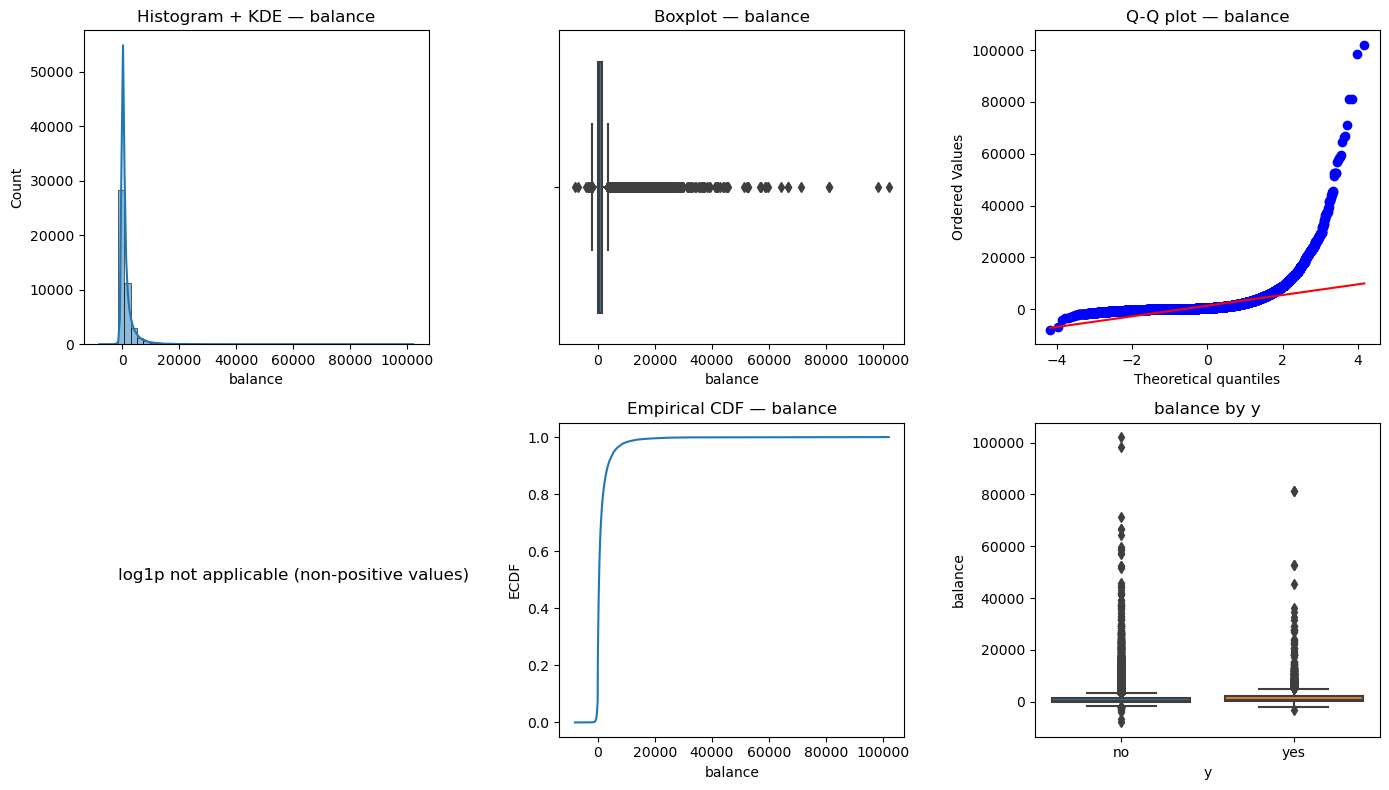


Column: day
       count       mean       std  min   1%   5%  10%  25%   50%   75%   90%  \
day  45211.0  15.806419  8.322476  1.0  2.0  3.0  5.0  8.0  16.0  21.0  28.0   

      95%   99%   max  
day  29.0  31.0  31.0  
skew: 0.09307901402122411 kurtosis: -1.0598973728286003


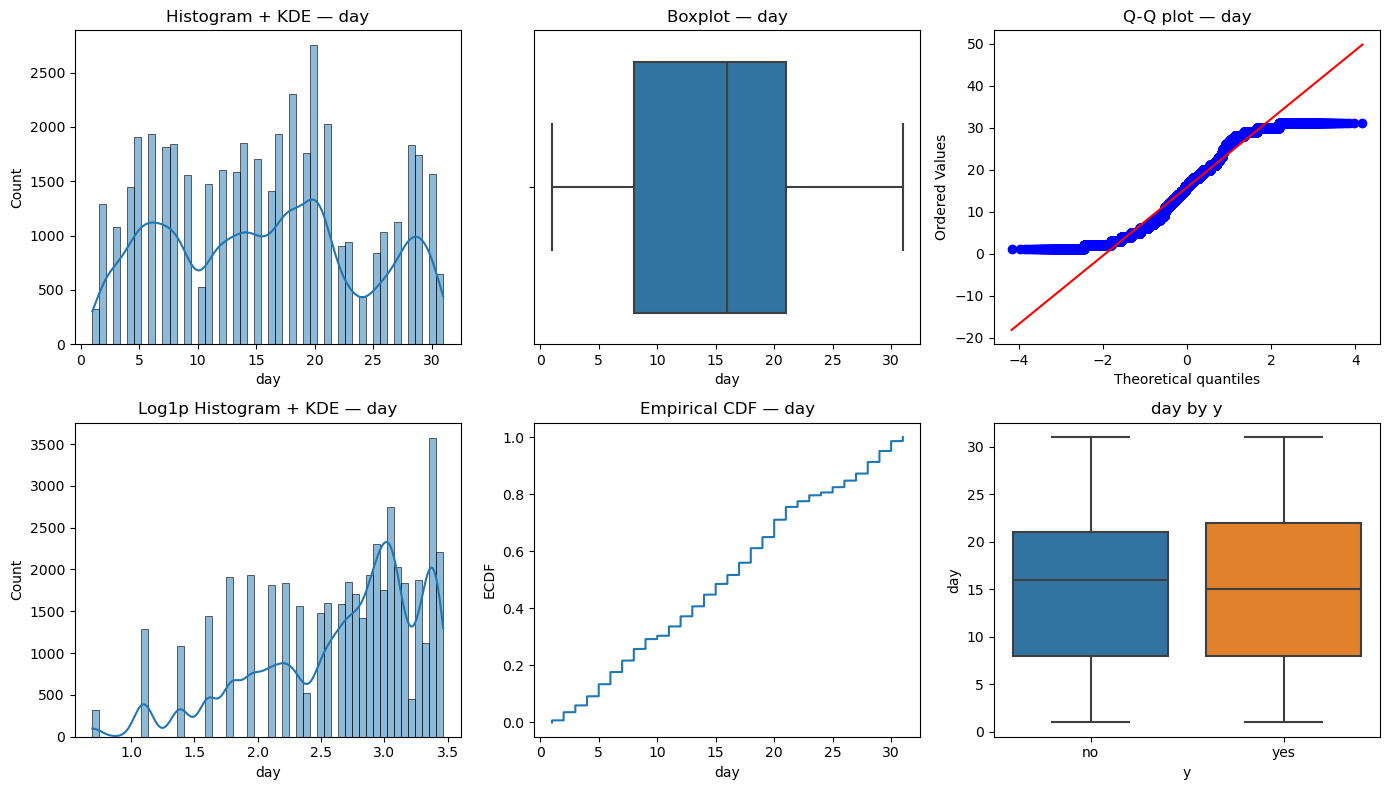


Column: duration
            count       mean         std  min    1%    5%   10%    25%    50%  \
duration  45211.0  258.16308  257.527812  0.0  11.0  35.0  58.0  103.0  180.0   

            75%    90%    95%     99%     max  
duration  319.0  548.0  751.0  1269.0  4918.0  
skew: 3.144318099423456 kurtosis: 18.153915269019706


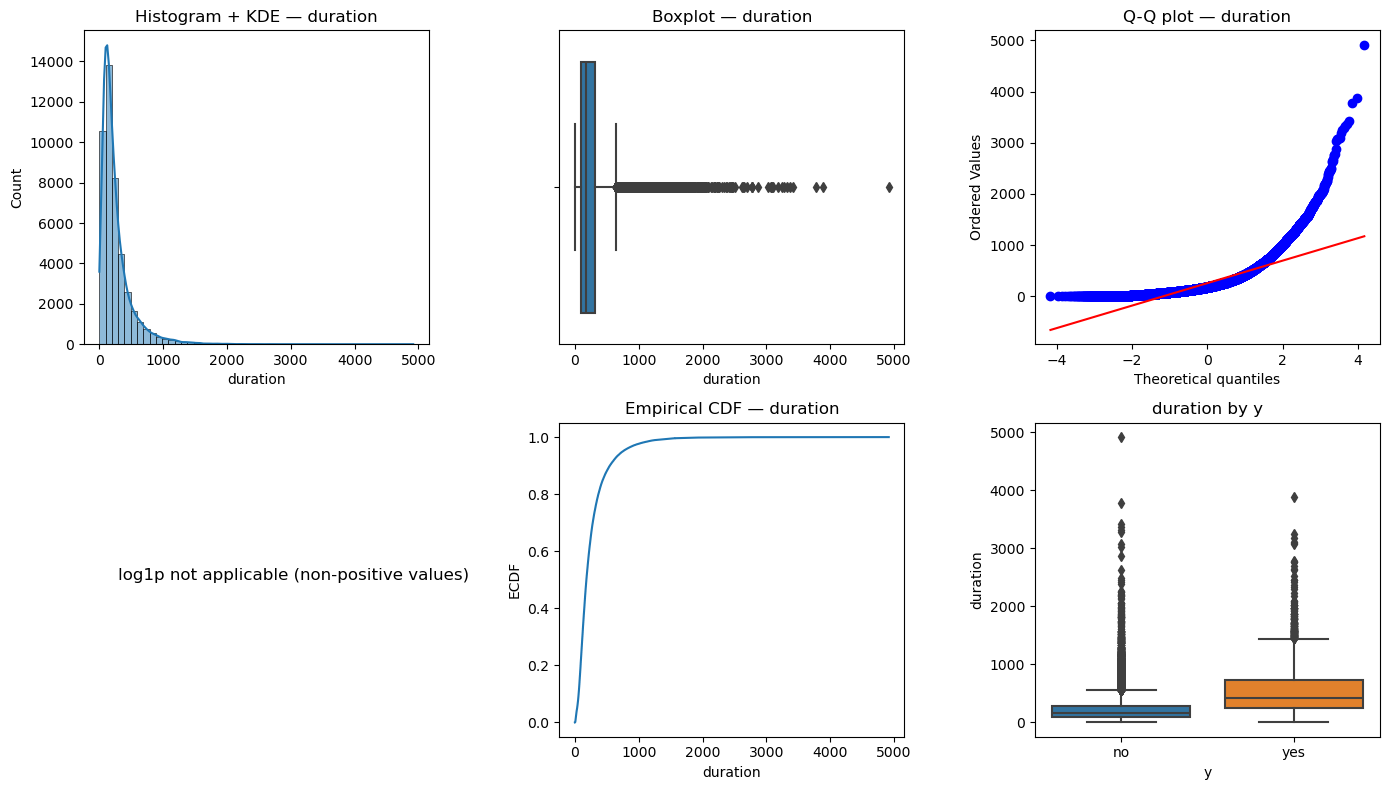


Column: campaign
            count      mean       std  min   1%   5%  10%  25%  50%  75%  90%  \
campaign  45211.0  2.763841  3.098021  1.0  1.0  1.0  1.0  1.0  2.0  3.0  5.0   

          95%   99%   max  
campaign  8.0  16.0  63.0  
skew: 4.898650166179674 kurtosis: 39.2496508023021


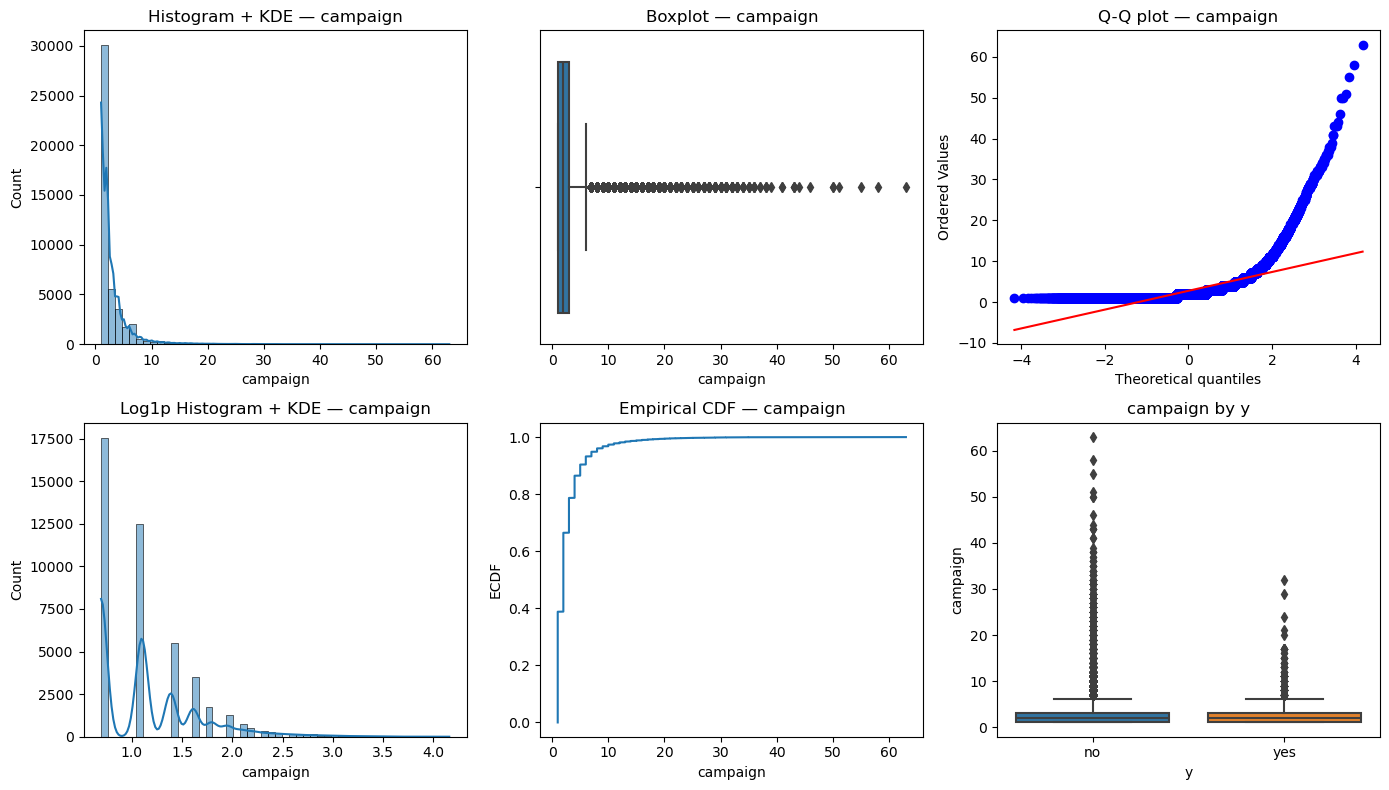


Column: pdays
         count       mean        std  min   1%   5%  10%  25%  50%  75%  \
pdays  45211.0  41.015195  99.792615  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

         90%    95%    99%    max  
pdays  185.0  317.0  370.0  871.0  
skew: 2.621749778366734 kurtosis: 6.981205779923048


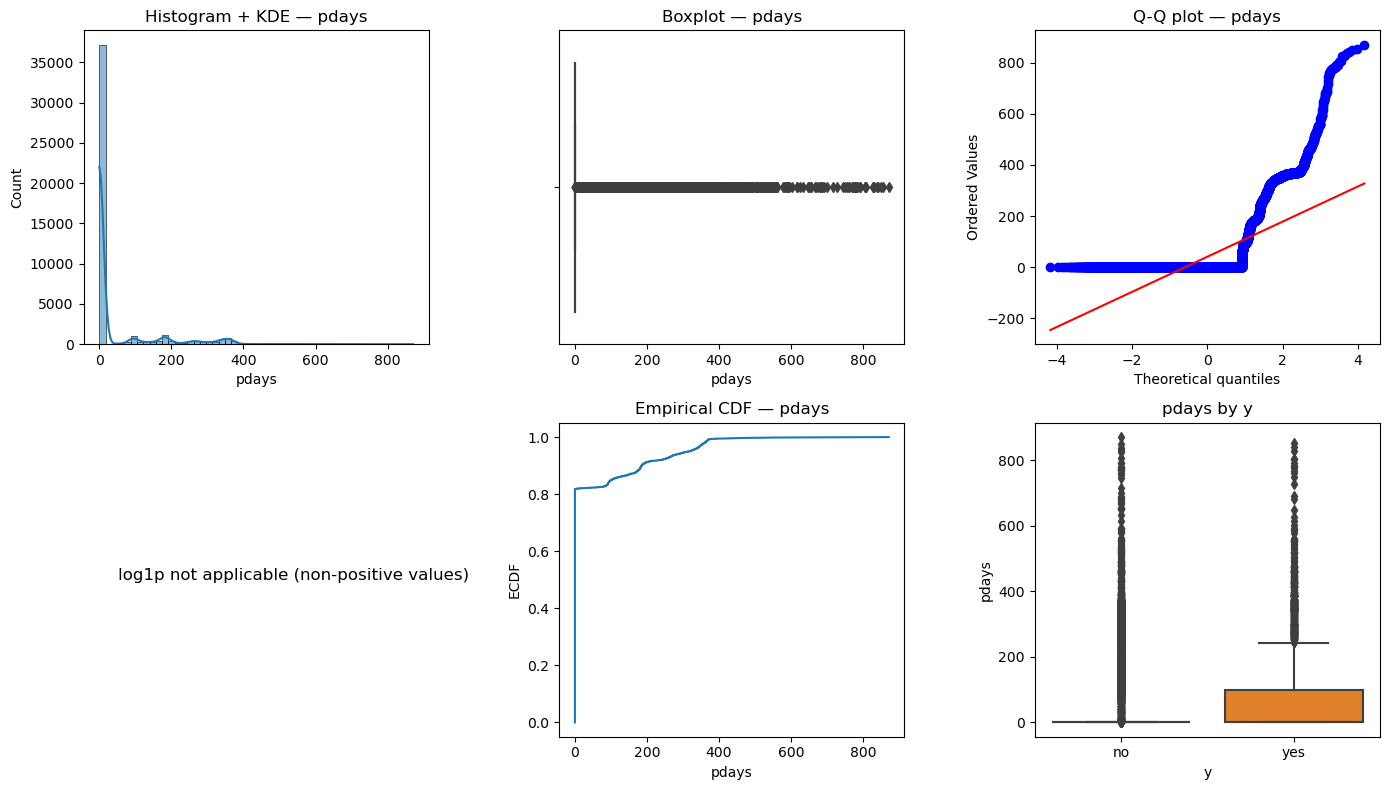


Column: previous
            count      mean       std  min   1%   5%  10%  25%  50%  75%  90%  \
previous  45211.0  0.580323  2.303441  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   

          95%  99%    max  
previous  3.0  8.9  275.0  
skew: 41.84645447266292 kurtosis: 4506.860660183261


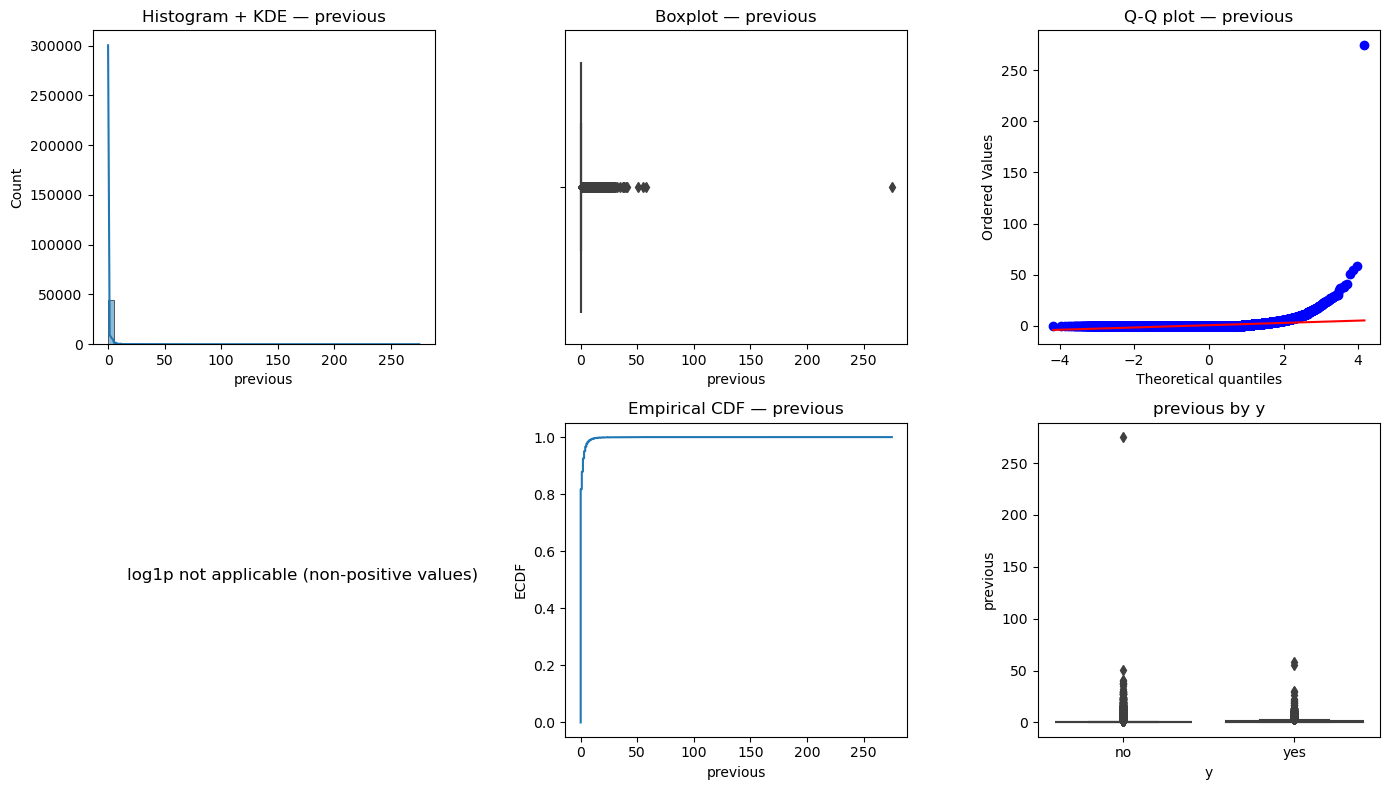


Column: no_prev_contact
                   count      mean       std  min   1%   5%  10%  25%  50%  \
no_prev_contact  45211.0  0.817367  0.386369  0.0  0.0  0.0  0.0  1.0  1.0   

                 75%  90%  95%  99%  max  
no_prev_contact  1.0  1.0  1.0  1.0  1.0  
skew: -1.6428920856664098 kurtosis: 0.6991253304109954


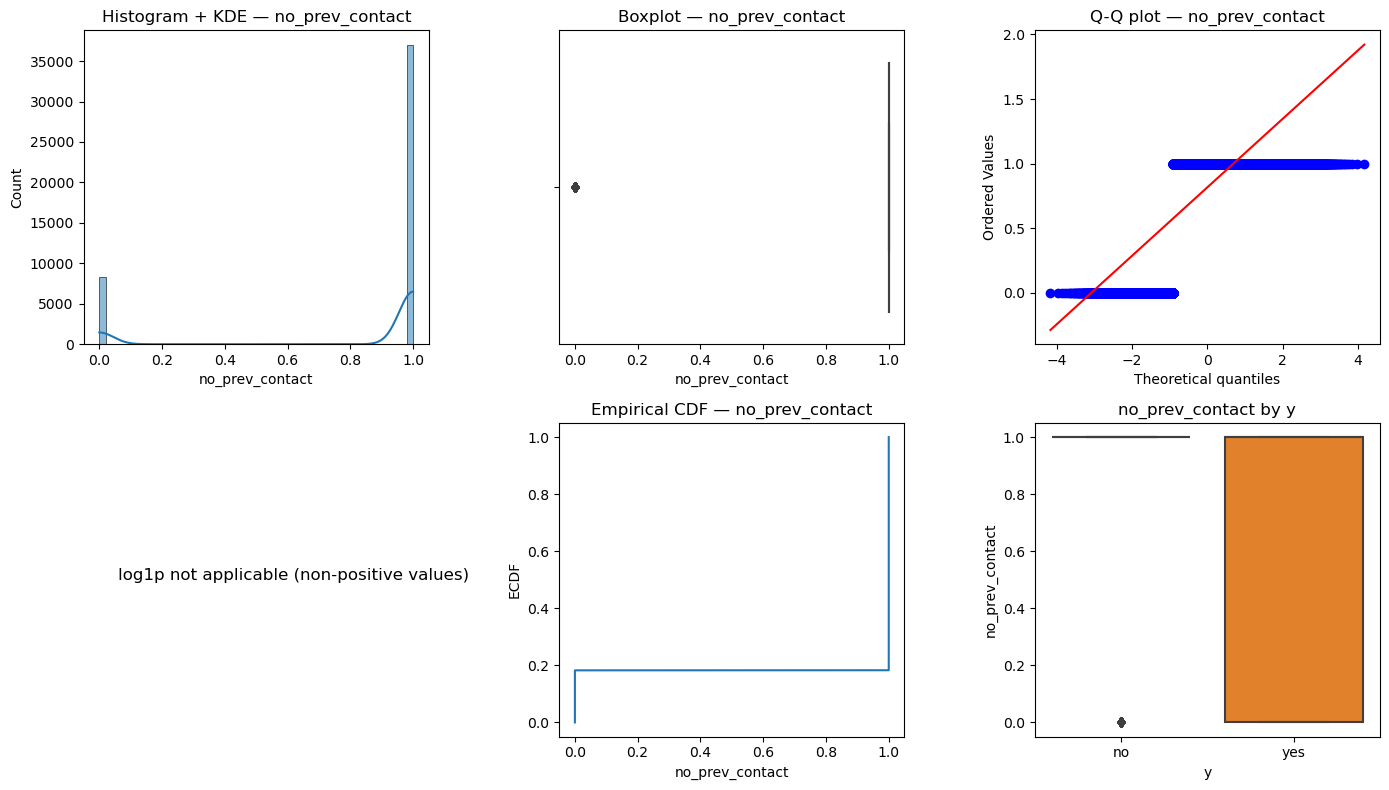

In [23]:
def plot_numeric_diagnostics(df, col, save=True, figsize=(14,8)):
    data = df[col].dropna()
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    sns.histplot(data, bins=50, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram + KDE — {col}')
    
    sns.boxplot(x=data, ax=axes[0,1])
    axes[0,1].set_title(f'Boxplot — {col}')
    
    # QQ plot
    stats.probplot(data, dist="norm", plot=axes[0,2])
    axes[0,2].set_title(f'Q-Q plot — {col}')
    
    # log1p histogram (if data are positive and dispersion is large)
    if (data > 0).all():
        sns.histplot(np.log1p(data), bins=50, kde=True, ax=axes[1,0])
        axes[1,0].set_title(f'Log1p Histogram + KDE — {col}')
    else:
        axes[1,0].text(0.1, 0.5, 'log1p not applicable (non-positive values)', fontsize=12)
        axes[1,0].axis('off')
    
    # Empirical CDF
    sorted_vals = np.sort(data)
    yvals = np.arange(1, len(sorted_vals)+1) / float(len(sorted_vals))
    axes[1,1].plot(sorted_vals, yvals)
    axes[1,1].set_title(f'Empirical CDF — {col}')
    axes[1,1].set_xlabel(col)
    axes[1,1].set_ylabel('ECDF')
    
    # Boxplot by target (if binary)
    if target_col in df.columns:
        try:
            sns.boxplot(x=df[target_col], y=df[col], ax=axes[1,2])
            axes[1,2].set_title(f'{col} by {target_col}')
        except Exception:
            axes[1,2].axis('off')
    else:
        axes[1,2].axis('off')
    
    plt.tight_layout()
    if save:
        plt.savefig(f'figures/{col}_diagnostics.png', bbox_inches='tight')
    plt.show()

for col in num_cols:
    print("\n" + "="*80)
    print(f"Column: {col}")
    print(df_clean[col].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).to_frame().T)
    # skewness / kurtosis
    print("skew:", df_clean[col].skew(), "kurtosis:", df_clean[col].kurtosis())
    plot_numeric_diagnostics(df_clean, col, save=True)

### Result of distribution analysis
1) Age
   * Quartiles are: 33, 39, 48
   * Distribution is close to normal but still got a tail to right with some exteme values
   * Median is 39 (have outliers for right)
   * Log scaling relatively handles inequalty in distribution
   * By target, medians are almost equal, but IQR in 'yes' is quite higher than 'no'
2) Balance
   * Quartiles are: 72, 448, 1428
   * Distribution is much skewed to right and have big tail
   * Median is 448 and lot of outliers (especially for right part)
   * Log scaling is not applicable as there are negative values (that indicate debts)
   * By target, they are almost equal, both has many outliers, but for 'no' there are much more outliers
3) Day
   * Quartiles are: 8, 16, 21
   * Distribution looks like Uniform
   * Overall, there are no outliers as their range is (0, 31)
4) Duration
   * Quartiles are: 103, 180, 319
   * Distribution is skewed to the right and got many extreme values
   * Median is 180 and lot of outliers (for right)
   * Log scaling is not applicable as there are 0 values
   * By target, both have many outliers, but 'no' has more, but IQR and quartiles are significantly lower than 'yes'
5) Campaign
   * Quartiles are: 1, 2, 3
   * Distribution is skewed to the right and got many extreme values
   * Median is 2 and lot of outliers (for right)
   * Log scaling can't handle outliers
   * By target, 'no' has more outliers, but IQR and quartiles are significantly lower
   * By target, both are similar in IQR and a huge number of outliers, but 'no' has more outliers
6) Pdays
   * Quartiles are: 0, 0, 0
   * Distribution is skewed to the right and got many extreme values
   * Most imbalanced feature, almost all values are outliers
   * Log scaling is not applicable as there are 0 values
   * By target, 'no' consist almost fully of outliers, while 'yes' IQR is ~ 100 and also got a lot of outliers
7) Previous
   * Quartiles are: 0, 0, 0
   * Distribution is skewed to the right and got many extreme values
   * Most imbalanced feature, almost all values are outliers
   * Log scaling is not applicable as there are 0 values
   * By target, both consist almost fully of outliers, but 'no' stands out because of one enormous outlier among others

### IQR & z-score outliers summary - for each numeric: borders, outliers by IQR, by z-score (>3)

In [24]:
outlier_summary = []
for col in num_cols:
    col_data = df_clean[col].dropna()
    q1 = col_data.quantile(0.25)
    q3 = col_data.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_iqr = ((col_data < lower) | (col_data > upper)).sum()
    pct_iqr = n_iqr / col_data.shape[0] * 100
    
    # z-score method
    zs = np.abs(stats.zscore(col_data, nan_policy='omit'))
    n_z3 = (zs > 3).sum()
    pct_z3 = n_z3 / col_data.shape[0] * 100
    
    outlier_summary.append({
        'feature': col,
        'count': col_data.shape[0],
        'q1': q1, 'q3': q3, 'iqr': iqr,
        'lower_iqr': lower, 'upper_iqr': upper,
        'n_out_iqr': n_iqr, 'pct_out_iqr': pct_iqr,
        'n_out_z3': n_z3, 'pct_out_z3': pct_z3
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('pct_out_iqr', ascending=False)
display(outlier_df)
outlier_df.to_csv('figures/outlier_summary.csv', index=False)

,feature,count,q1,q3,iqr,lower_iqr,upper_iqr,n_out_iqr,pct_out_iqr,n_out_z3,pct_out_z3
5,pdays,45211,0.0,0.0,0.0,0.0,0.0,8257,18.263255,1723,3.811019
6,previous,45211,0.0,0.0,0.0,0.0,0.0,8257,18.263255,582,1.287297
7,no_prev_contact,45211,1.0,1.0,0.0,1.0,1.0,8257,18.263255,0,0.000000
1,balance,45211,72.0,1428.0,1356.0,-1962.0,3462.0,4729,10.459844,745,1.647829
3,duration,45211,103.0,319.0,216.0,-221.0,643.0,3235,7.155338,963,2.130013
4,campaign,45211,1.0,3.0,2.0,-2.0,6.0,3064,6.777112,840,1.857955
0,age,45211,33.0,48.0,15.0,10.5,70.5,487,1.077171,381,0.842715
2,day,45211,8.0,21.0,13.0,-11.5,40.5,0,0.000000,0,0.000000


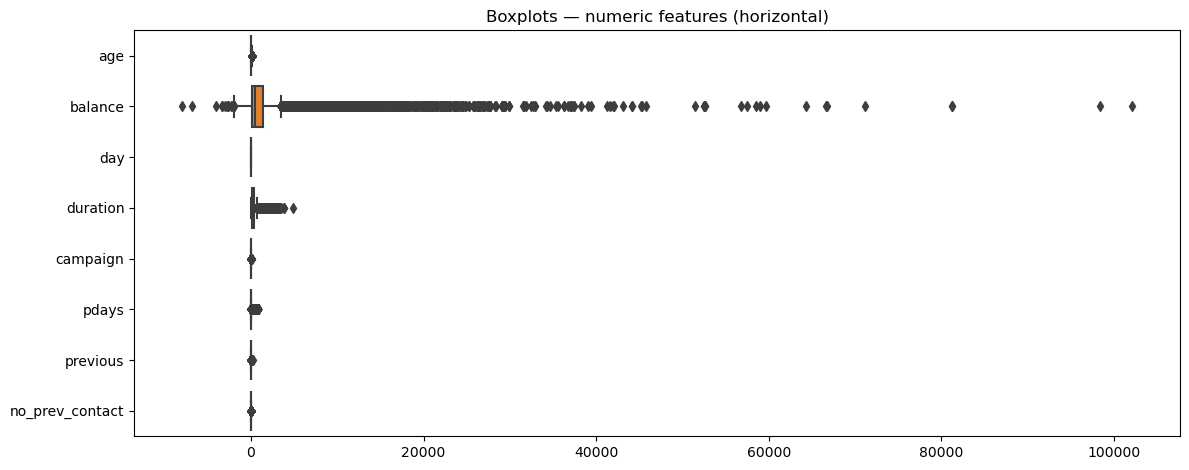

In [25]:
plt.figure(figsize=(12, max(4, 0.6*len(num_cols))))
sns.boxplot(data=df_clean[num_cols].fillna(0), orient='h')  # fillna only for plotting
plt.title('Boxplots — numeric features (horizontal)')
plt.tight_layout()
plt.savefig('figures/all_boxplots.png', bbox_inches='tight')
plt.show()

Boxplot comparing shows outliers in all features again and we see that 'balance' is leader here 

# Data Visualization

Categorical values: countplots и share of target
### Top categories (or top 10 if many unique)


------------------------------------------------------------
Categorical: job (unique: 12)


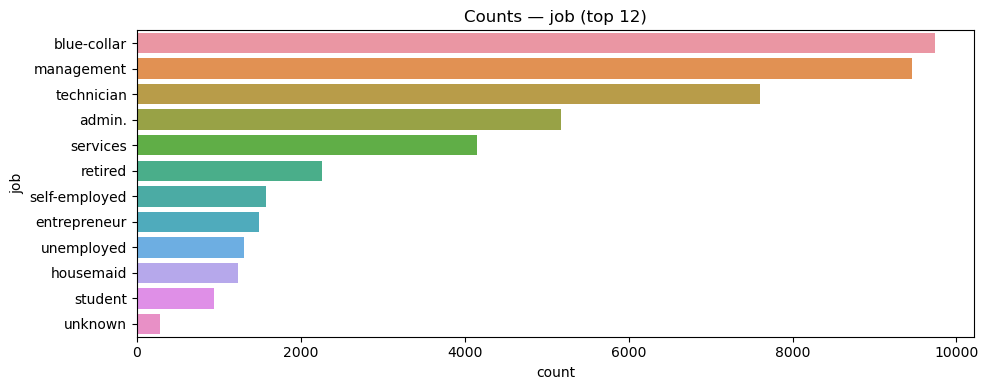

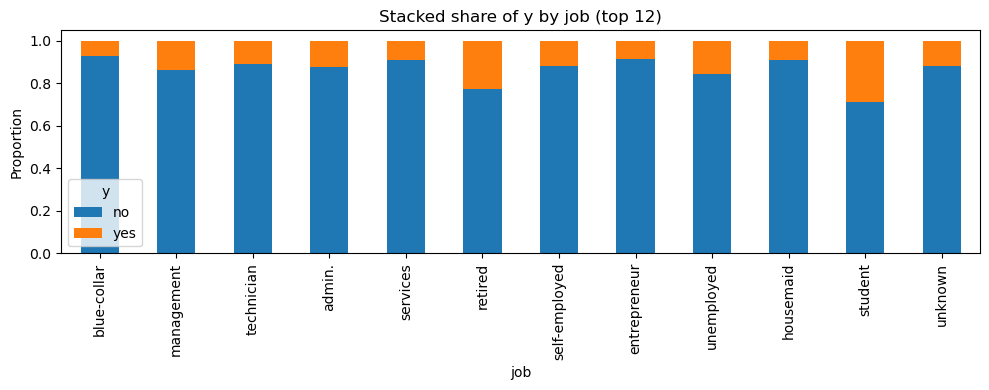


------------------------------------------------------------
Categorical: marital (unique: 3)


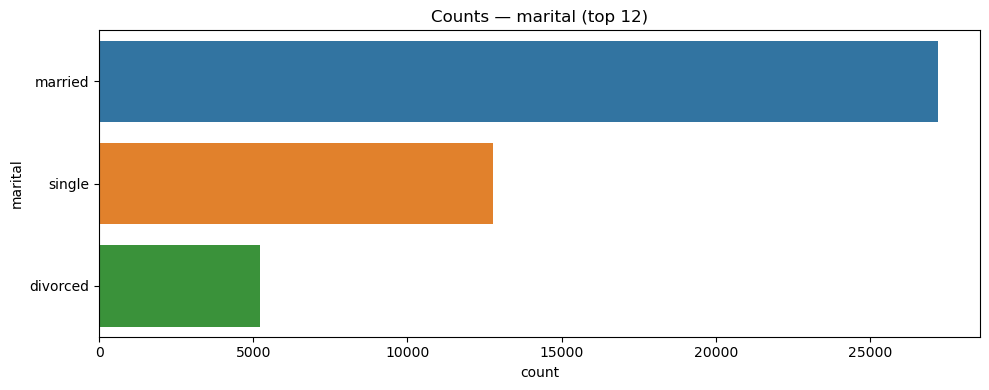

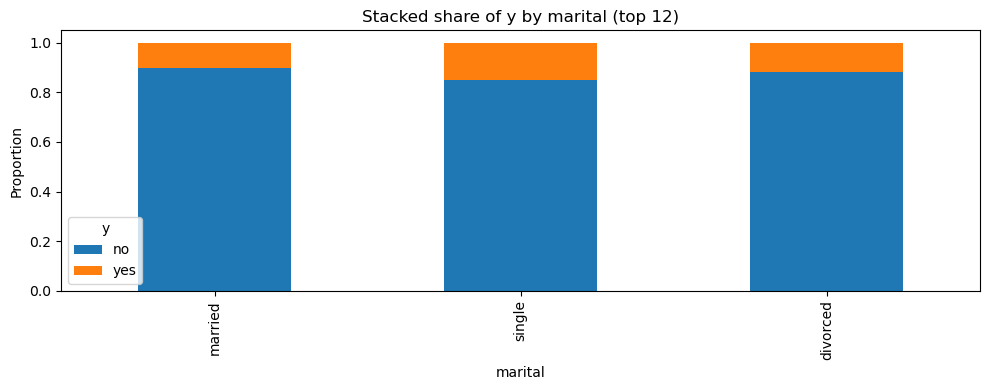


------------------------------------------------------------
Categorical: education (unique: 4)


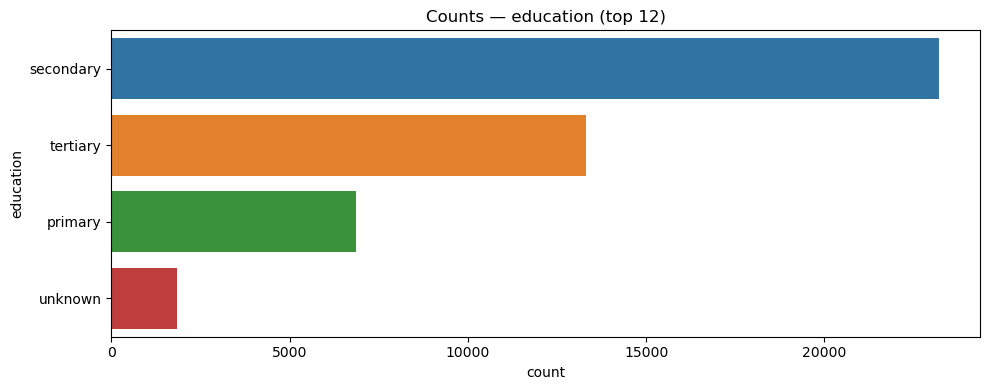

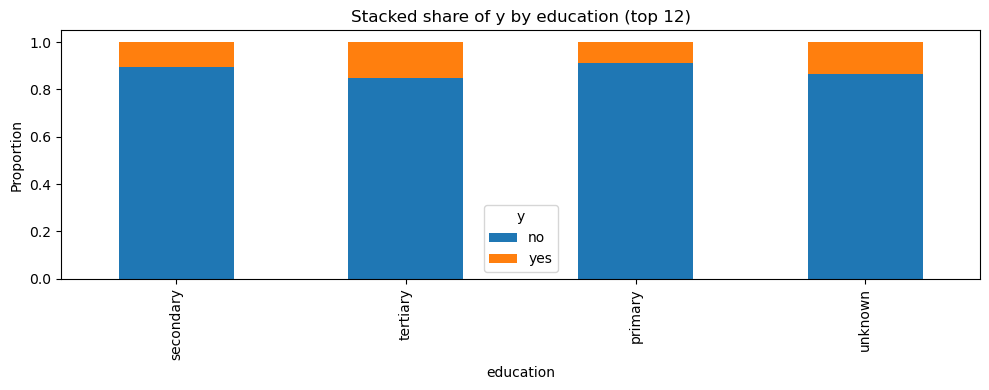


------------------------------------------------------------
Categorical: default (unique: 2)


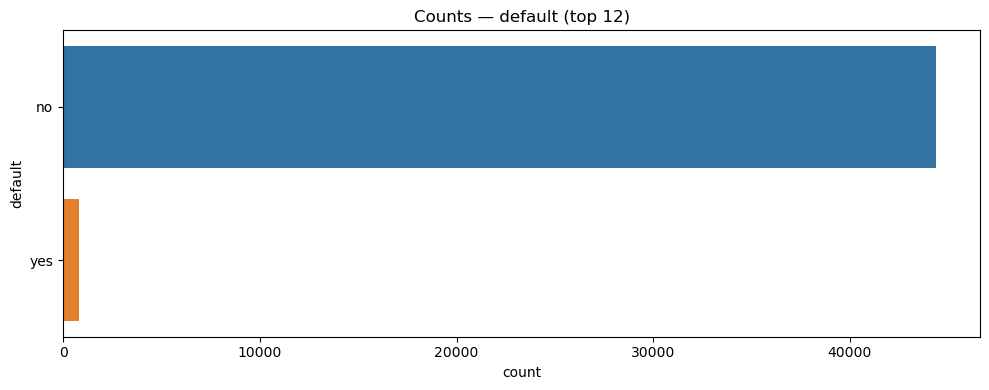

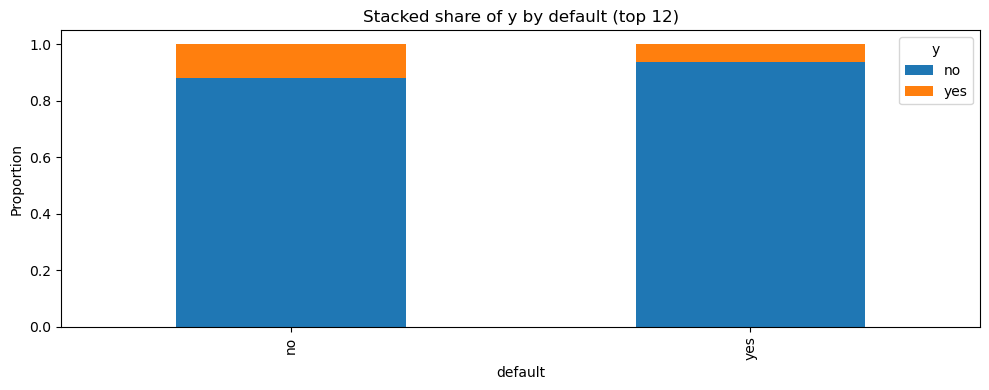


------------------------------------------------------------
Categorical: housing (unique: 2)


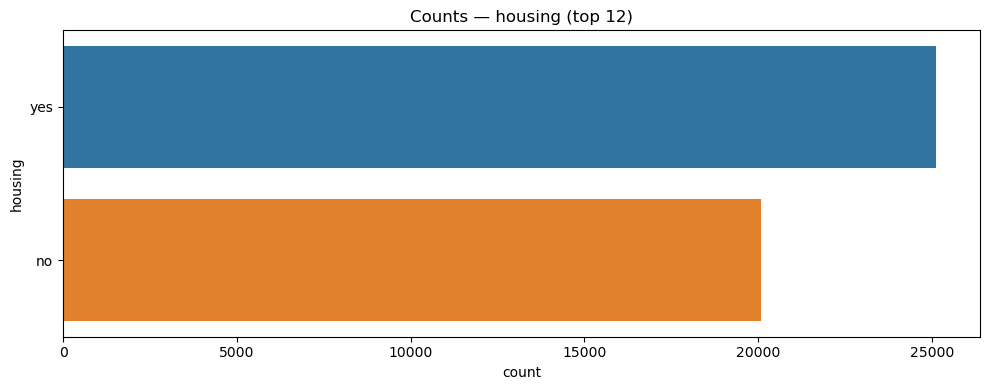

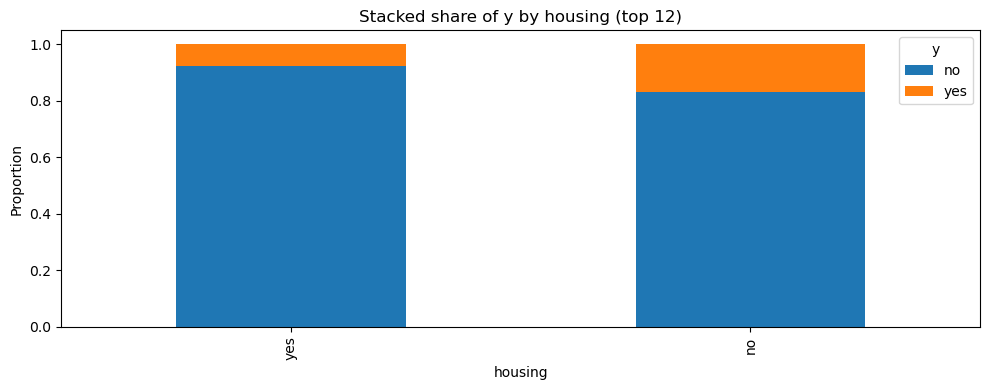


------------------------------------------------------------
Categorical: loan (unique: 2)


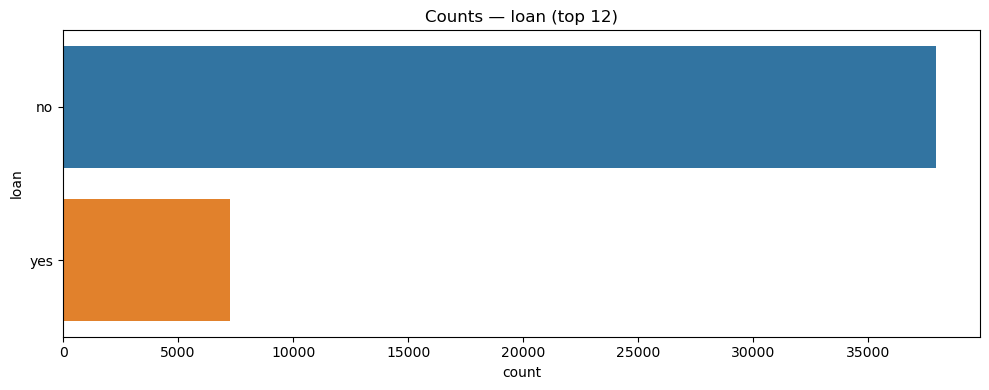

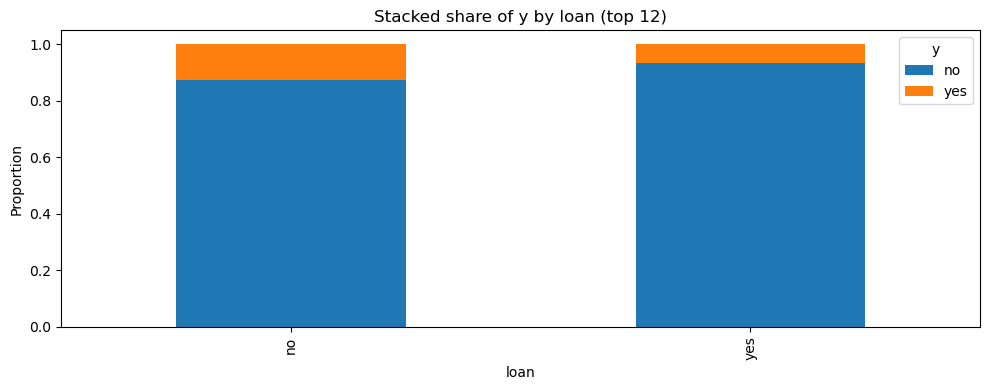


------------------------------------------------------------
Categorical: contact (unique: 3)


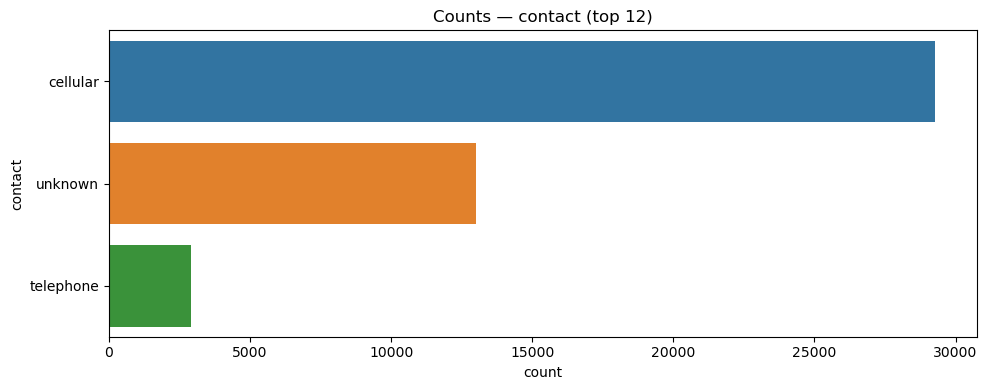

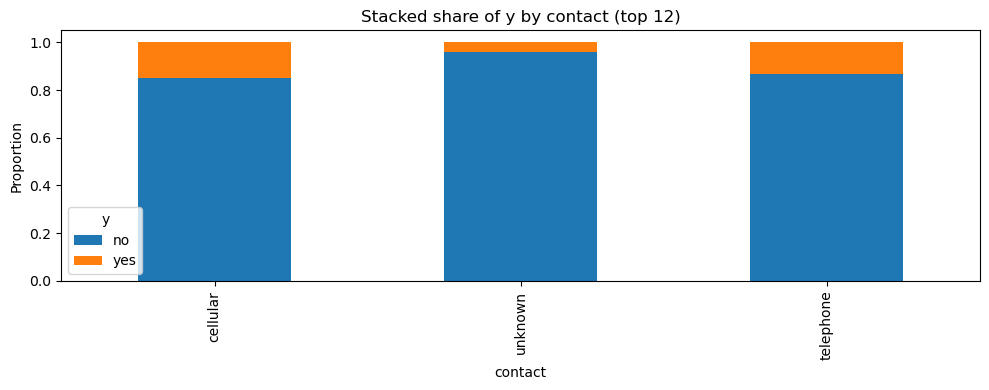


------------------------------------------------------------
Categorical: month (unique: 12)


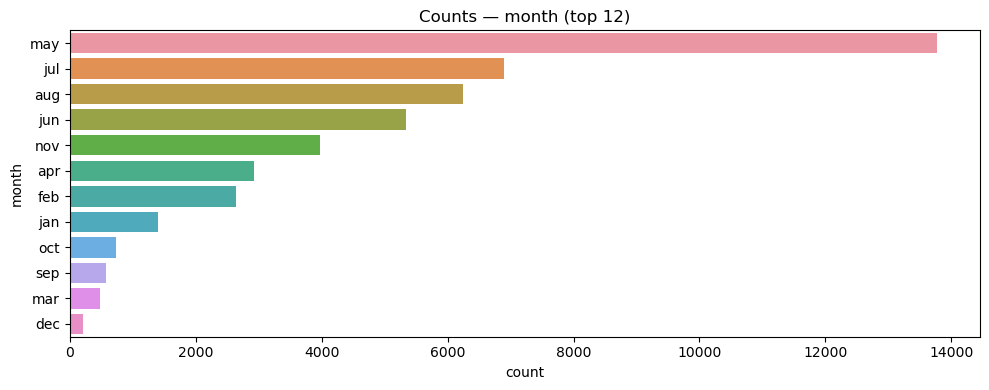

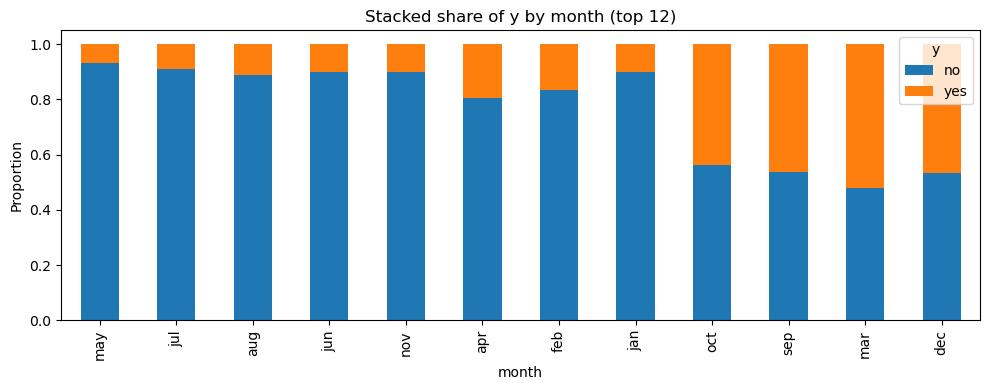


------------------------------------------------------------
Categorical: poutcome (unique: 4)


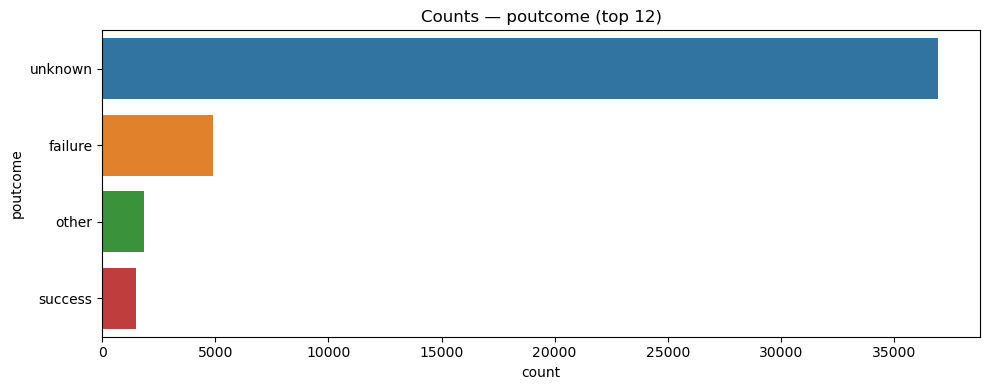

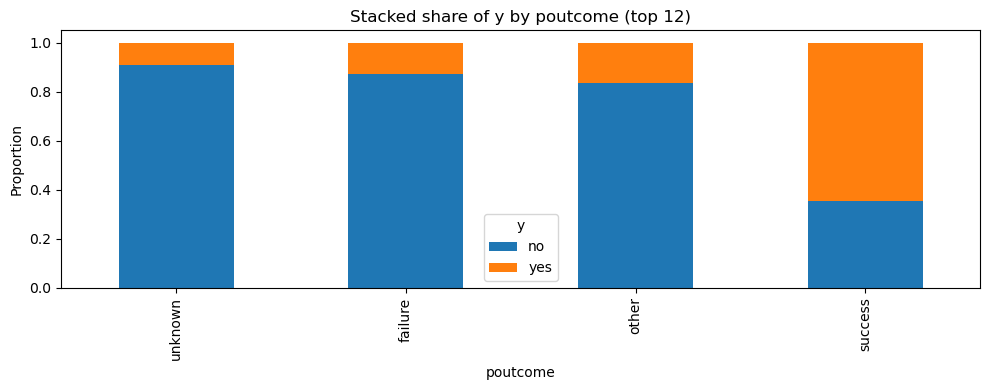

In [26]:
def plot_categorical_counts_and_target(df, col, top_n=10, save=True):
    # frequency
    vc = df[col].value_counts(dropna=False)
    top = vc.index[:top_n]
    plt.figure(figsize=(10,4))
    sns.countplot(y=col, order=top, data=df)
    plt.title(f'Counts — {col} (top {top_n})')
    plt.tight_layout()
    if save:
        plt.savefig(f'figures/{col}_counts.png', bbox_inches='tight')
    plt.show()
    
    # share by target (stacked bar like)
    if target_col in df.columns:
        cross = pd.crosstab(df[col], df[target_col], normalize='index').loc[top]
        cross.plot(kind='bar', stacked=True, figsize=(10,4))
        plt.title(f'Stacked share of {target_col} by {col} (top {top_n})')
        plt.ylabel('Proportion')
        plt.tight_layout()
        if save:
            plt.savefig(f'figures/{col}_target_share.png', bbox_inches='tight')
        plt.show()

for col in cat_cols:
    print("\n" + "-"*60)
    print(f"Categorical: {col} (unique: {df_clean[col].nunique()})")
    plot_categorical_counts_and_target(df_clean, col, top_n=12, save=True)

### Interpretation of visualizations:
* Retired and student take deposts significantly higher that others
* Blue-collars, managment and technicians are majority in jobs
* Most of people are married
* Single people take deposits more often
* Most of people have secondary education
* People with tertiary education usually more often take deposits
* Most of people don't default and they take more deposits
* More people have housing loan but than no and less take deposts
* Majority of people don't have personal loan and they take deposits more often
* Majority of people contact in cellular way and take more deposits
* Most of deposits are taken in May with a huge separation, but in % division the leaders are October, September, March and December
* Outcome of the previous marketing campaign is more unknown, but in % division it is 'success'


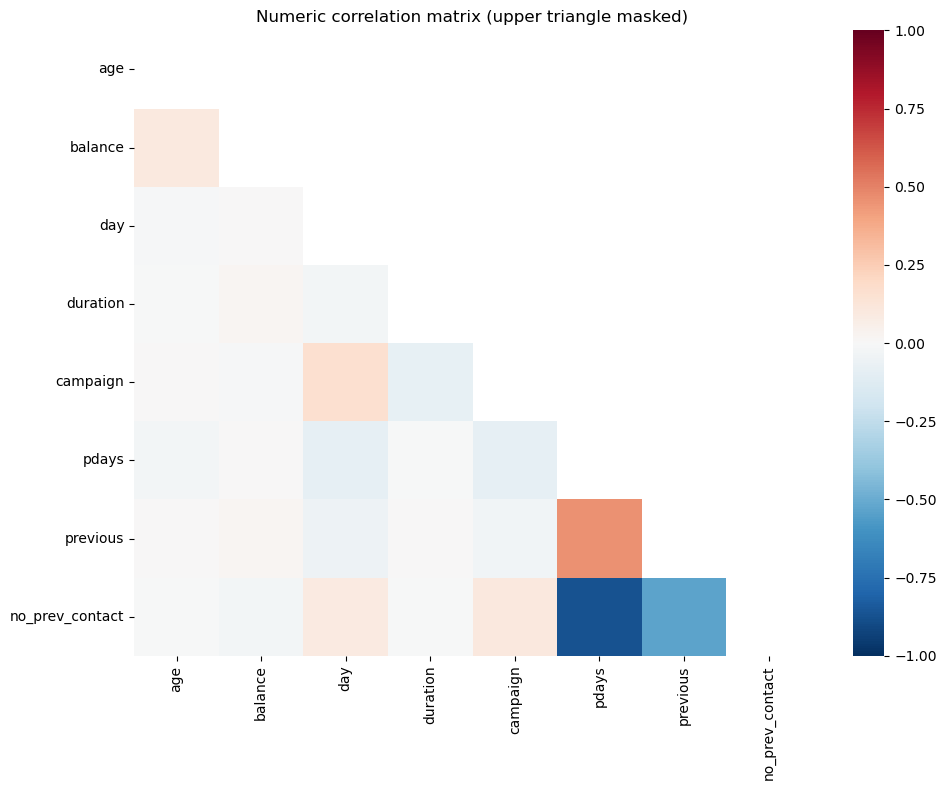

In [27]:
plt.figure(figsize=(10,8))
corr = df_clean[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Numeric correlation matrix (upper triangle masked)')
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', bbox_inches='tight')
plt.show()

### Heatmap interpretaion
1) Positive correlations
   * Balance & Age (0 - 0.25)
   * Day & Campaign (0 - 0.25)
   * Day & no_prev_contact (0 - 0.25)
   * Campaign & no_prev_contact (0 - 0.25)
   * pdays and previous (0.25 - 0.50)
2) Negative correlations
   * previous & no_prev_contact (0.5 - 0.75)
   * pdays & no_prev_contact (0.75 - 1)

Overall, negative correlations are mostly stronger, while postives are more but weaker. Most correlated features are 'pdays' and 'no_prev_contact'

### Relational plots - Pairwise scatter for selected numeric features (sampled if large)


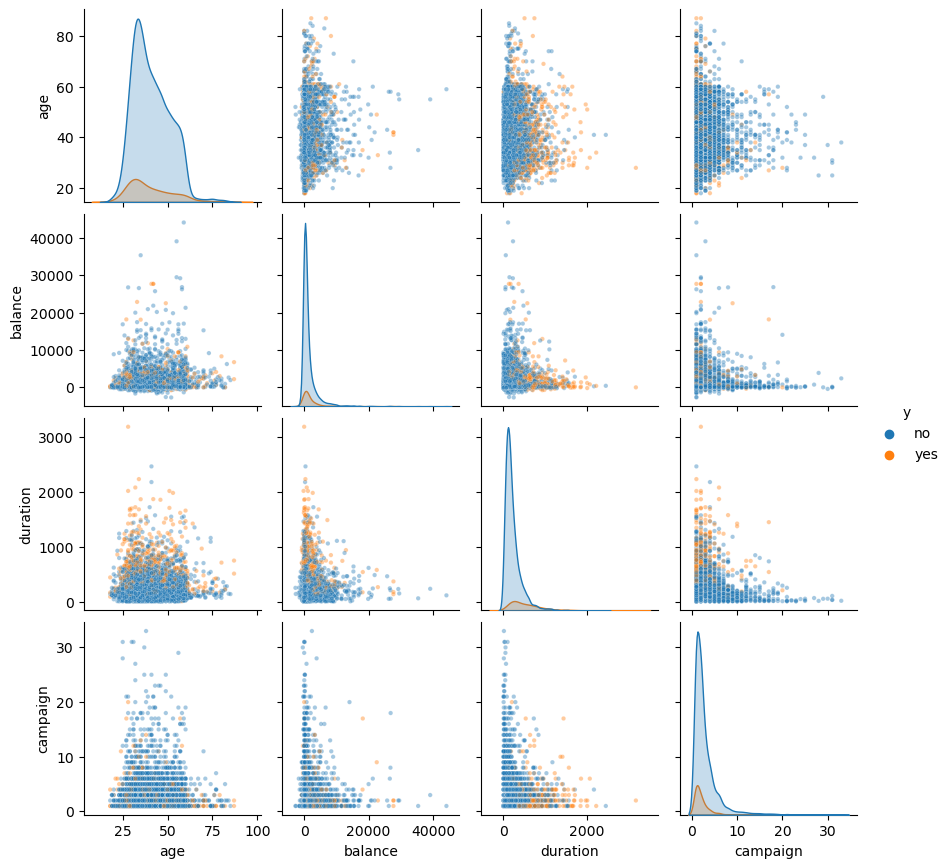

In [28]:

pair_cols = ['age', 'balance', 'duration', 'campaign']
pair_cols = [c for c in pair_cols if c in df_clean.columns]
sample = df_clean.sample(n=min(5000, df_clean.shape[0]), random_state=42)
sns.pairplot(sample[pair_cols + [target_col]] if target_col in sample.columns else sample[pair_cols],
             hue=target_col if target_col in sample.columns else None,
             plot_kws={'alpha':0.4, 's':10}, height=2.2)
plt.savefig('figures/pairplot_sample.png', bbox_inches='tight')
plt.show()


Top outliers rows (based on the total number of features that are outliers). For each row, we count the number of values ​​that fall outside the IQR limits.

In [30]:
outlier_flags = pd.DataFrame(index=df_clean.index)
for col in num_cols:
    col_data = df_clean[col]
    q1 = col_data.quantile(0.25)
    q3 = col_data.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_flags[col + '_o'] = ((col_data < lower) | (col_data > upper)).astype(int)

outlier_flags['n_outliers'] = outlier_flags.sum(axis=1)
top_out_rows = outlier_flags['n_outliers'].sort_values(ascending=False).head(20)
print("Top rows with most IQR-outliers (index : count):")
print(top_out_rows.head(20))
display(df_clean.loc[top_out_rows.index].head(20))
outlier_flags['n_outliers'].to_csv('figures/row_outlier_counts.csv')

Top rows with most IQR-outliers (index : count):
45056    6
42730    6
42996    6
44746    6
43893    6
42558    6
43722    6
43423    6
43731    6
42859    6
41754    6
43142    6
42325    6
45208    6
30746    5
34921    5
38873    5
42208    5
44226    5
25789    5
Name: n_outliers, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,no_prev_contact
45056,64,management,married,tertiary,no,5112,no,no,telephone,19,oct,898,7,137,11,other,yes,0
42730,77,retired,married,secondary,no,4112,no,no,telephone,26,jan,1616,1,95,2,success,yes,0
42996,75,blue-collar,married,secondary,no,6053,no,no,cellular,11,feb,865,2,190,1,failure,no,0
44746,84,retired,married,tertiary,no,4761,no,no,telephone,9,sep,1405,1,92,3,failure,yes,0
43893,80,retired,married,secondary,no,8304,no,no,telephone,9,jun,712,1,64,12,failure,yes,0
42558,84,retired,married,secondary,no,81204,no,no,telephone,28,dec,679,1,313,2,other,yes,0
43722,75,retired,married,tertiary,no,6027,no,no,cellular,14,may,809,1,179,4,success,yes,0
43423,80,retired,married,secondary,no,8304,no,no,telephone,6,apr,681,1,118,11,success,no,0
43731,72,retired,married,secondary,no,5715,no,no,cellular,17,may,1114,1,181,2,success,yes,0
42859,78,retired,married,unknown,no,4807,no,no,telephone,3,feb,892,2,104,4,success,yes,0


In [31]:
for _, r in outlier_df.iterrows():
    col = r['feature']
    pct = r['pct_out_iqr']
    if pct > 5:
        print(f"- {col}: {pct:.2f}% values — potential outliers (IQR).")
    elif pct > 1:
        print(f"- {col}: {pct:.2f}% values — not many outliers.")
    else:
        print(f"- {col}: outliers are are ({pct:.2f}%).")

- pdays: 18.26% values — potential outliers (IQR).
- previous: 18.26% values — potential outliers (IQR).
- no_prev_contact: 18.26% values — potential outliers (IQR).
- balance: 10.46% values — potential outliers (IQR).
- duration: 7.16% values — potential outliers (IQR).
- campaign: 6.78% values — potential outliers (IQR).
- age: 1.08% values — not many outliers.
- day: outliers are are (0.00%).


# Handling outliers

### To deal with outliers I am going to use:
1) Winsorization
* change outliers on border values
* do not delete anything
* good for financial data
* make distributions more 'normal'
  
2) Log-transform
* Applied only to columns with positive values
* Deals with huge assymetry in data
* Not applicable to zero or negative values

I used IQR-based Winsorization, so borders are:
* lower = Q1 – 1.5 * IQR
* upper = Q3 + 1.5 * IQR

,mean_before,std_before,skew_before,kurtosis_before,mean_after,std_after,skew_after,kurtosis_after
balance,1362.272058,3044.765829,8.360308,140.751547,4.886901,3.789542,-1.581300,1.785798
duration,258.163080,257.527812,3.144318,18.153915,5.172903,0.904810,-0.402355,0.453507
campaign,2.763841,3.098021,4.898650,39.249651,1.155333,0.499439,1.153930,1.029313
pdays,41.015195,99.792615,2.621750,6.981206,0.954979,2.042835,1.708063,0.992773
previous,0.580323,2.303441,41.846454,4506.860660,0.222889,0.517003,2.321780,4.469989
age,40.936210,10.618762,0.684818,0.319570,40.887660,10.384267,0.552628,-0.354831


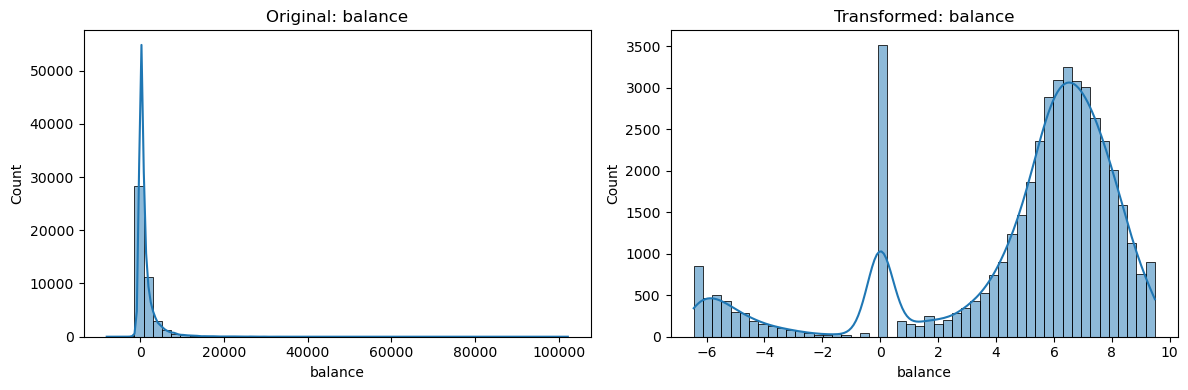

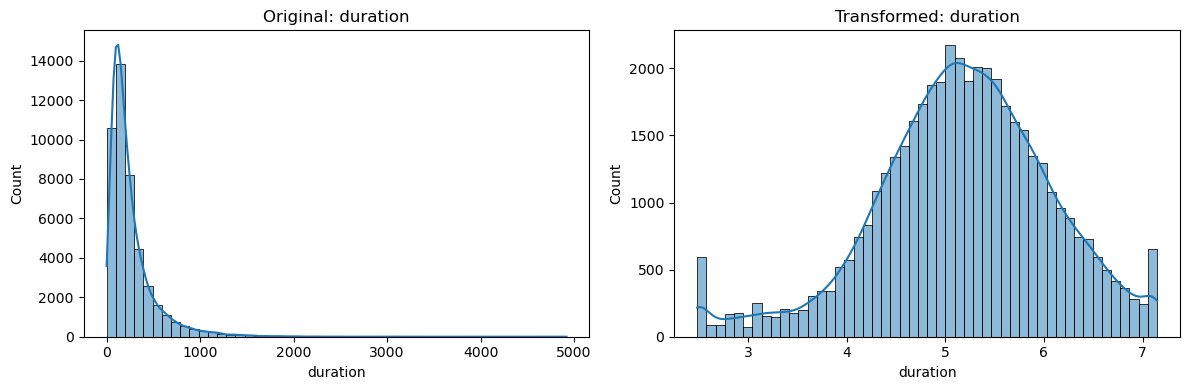

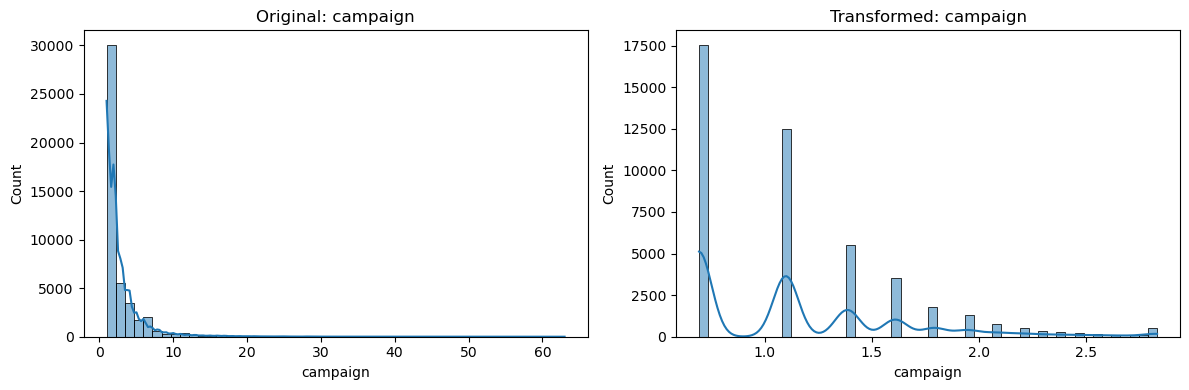

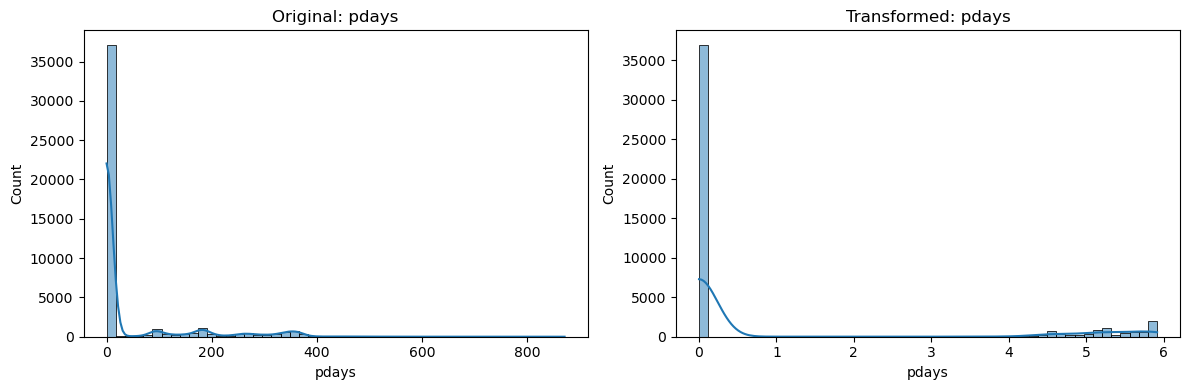

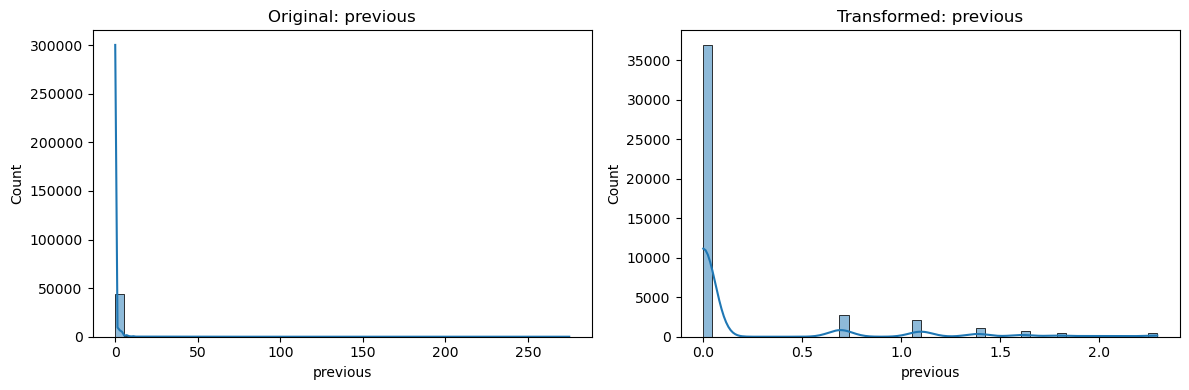

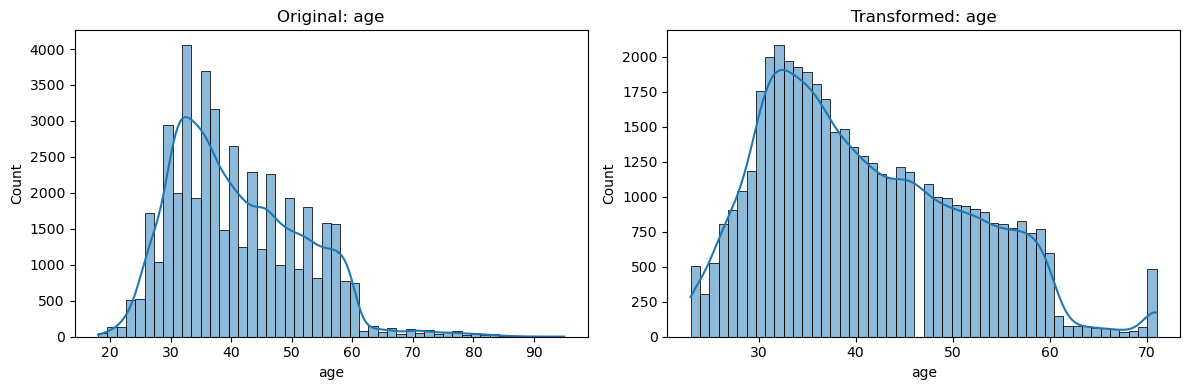

Winsorization bounds used:
 - duration: lower=11, upper=1269
 - campaign: lower=1, upper=16
 - pdays: lower=0, upper=370
 - previous: lower=0, upper=8.9
 - balance: lower=-627, upper=1.316e+04
 - age: lower=23, upper=71


In [32]:
# Columns to treat (only when present)
cols_winsor_log = [c for c in ['duration', 'campaign', 'pdays', 'previous'] if c in df_clean.columns]
col_signed_log = 'balance' if 'balance' in df_clean.columns else None
col_clip = 'age' if 'age' in df_clean.columns else None

# Work on a copy
df_trans = df_clean.copy()

# Ensure flag exists and convert -1 -> 0 for pdays
if 'pdays' in df_trans.columns:
    df_trans['no_prev_contact'] = (df_trans['pdays'] == -1).astype(int)
    df_trans['pdays'] = df_trans['pdays'].replace(-1, 0)

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high), low, high

def signed_log1p(s):
    return np.sign(s) * np.log1p(np.abs(s))

# Record before stats for selected columns
summary_before = {}
num_cols = []
if col_signed_log:
    num_cols.append(col_signed_log)
num_cols += cols_winsor_log
if col_clip:
    num_cols.append(col_clip)

for c in num_cols:
    ser = df_trans[c].dropna()
    summary_before[c] = {
        'count': int(ser.shape[0]),
        'mean': float(ser.mean()),
        'std': float(ser.std()),
        'skew': float(ser.skew()),
        'kurtosis': float(ser.kurtosis()),
        'p1': float(ser.quantile(0.01)),
        'p99': float(ser.quantile(0.99))
    }

# Apply winsorization + transforms
winsor_bounds = {}
for c in cols_winsor_log:
    df_trans[c], low, high = winsorize_series(df_trans[c], 0.01, 0.99)
    winsor_bounds[c] = (low, high)
    # log1p when non-negative
    if (df_trans[c] >= 0).all():
        df_trans[c] = np.log1p(df_trans[c])
    else:
        # if negatives present (rare), shift to positive before log
        minv = df_trans[c].min()
        if minv <= -1:
            shift = abs(minv) + 1
            df_trans[c] = np.log1p(df_trans[c] + shift)
        else:
            df_trans[c] = np.log1p(df_trans[c] + 1)

# Balance: winsorize then signed log
if col_signed_log:
    df_trans[col_signed_log], low_b, high_b = winsorize_series(df_trans[col_signed_log], 0.01, 0.99)
    winsor_bounds[col_signed_log] = (low_b, high_b)
    df_trans[col_signed_log] = signed_log1p(df_trans[col_signed_log])

# Age: clip to 1%-99%
if col_clip:
    low_a = df_trans[col_clip].quantile(0.01)
    high_a = df_trans[col_clip].quantile(0.99)
    df_trans[col_clip] = df_trans[col_clip].clip(lower=low_a, upper=high_a)
    winsor_bounds[col_clip] = (low_a, high_a)

# Record after stats
summary_after = {}
for c in num_cols:
    ser = df_trans[c].dropna()
    summary_after[c] = {
        'count': int(ser.shape[0]),
        'mean': float(ser.mean()),
        'std': float(ser.std()),
        'skew': float(ser.skew()),
        'kurtosis': float(ser.kurtosis()),
        'p1': float(ser.quantile(0.01)),
        'p99': float(ser.quantile(0.99))
    }

# Comparative table
before_df = pd.DataFrame(summary_before).T
after_df = pd.DataFrame(summary_after).T
comp = before_df.join(after_df, lsuffix='_before', rsuffix='_after')
display(comp[['mean_before','std_before','skew_before','kurtosis_before',
              'mean_after','std_after','skew_after','kurtosis_after']])

# Save before/after histograms
for c in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df_clean[c].dropna(), bins=50, kde=True)
    plt.title(f'Original: {c}')
    plt.subplot(1,2,2)
    sns.histplot(df_trans[c].dropna(), bins=50, kde=True)
    plt.title(f'Transformed: {c}')
    plt.tight_layout()
    plt.savefig(f'figures/{c}_before_after.png', bbox_inches='tight')
    plt.show()


print('Winsorization bounds used:')
for k,v in winsor_bounds.items():
    print(f' - {k}: lower={v[0]:.4g}, upper={v[1]:.4g}')


# ML part

After finishing EDA and working with data I am ready to apply ML models to solve the task

To encode I will mostly use one-hot encoding and LabelEncoder for binary columns

In [33]:
df_final = df_trans.copy()
X = df_final.drop("y", axis=1)
y = df_final["y"].map({"yes": 1, "no": 0})

binary_features = ["default", "housing", "loan"]
categorical_features = ["job", "marital", "education", "contact", "poutcome", "month", "day"]

for col in binary_features:
    X[col] = LabelEncoder().fit_transform(X[col])

ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), categorical_features)
    ],
    remainder="passthrough"
)

X_transformed = ct.fit_transform(X)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_sm))

Before SMOTE: [31937  4231]
After SMOTE: [31937 31937]


#### List of models I will use:
1. Logistic Regression
* captures global dependencies well.
* Interpretable (coefficients can be viewed).
* Usually weaker than trees, but has a good baseline.

2. Random Forest
* More powerful due to the ensemble of trees.
* Better at capturing complex dependencies.
* Robust to outliers and multicollinearity.
* Almost always produces good results.

3. XGBoost
* The most powerful model for tabular data.
* Can highlight weak signals in the data.
* Typically has the highest ROC-AUC.
* Provides good interpretation using feature_importances and SHAP.

#### Baseline

In [35]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )
}

results = []

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })



Logistic Regression

Random Forest

XGBoost


In [36]:
results_df = pd.DataFrame(results)
print("\nModel comparison")
display(results_df)


Model comparison


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.834236,0.399727,0.830813,0.539761,0.907380
1,Random Forest,0.905341,0.624691,0.478261,0.541756,0.929211
2,XGBoost,0.905452,0.633377,0.455577,0.529962,0.927857


#### Feature importance

Количество признаков после OHE: 72


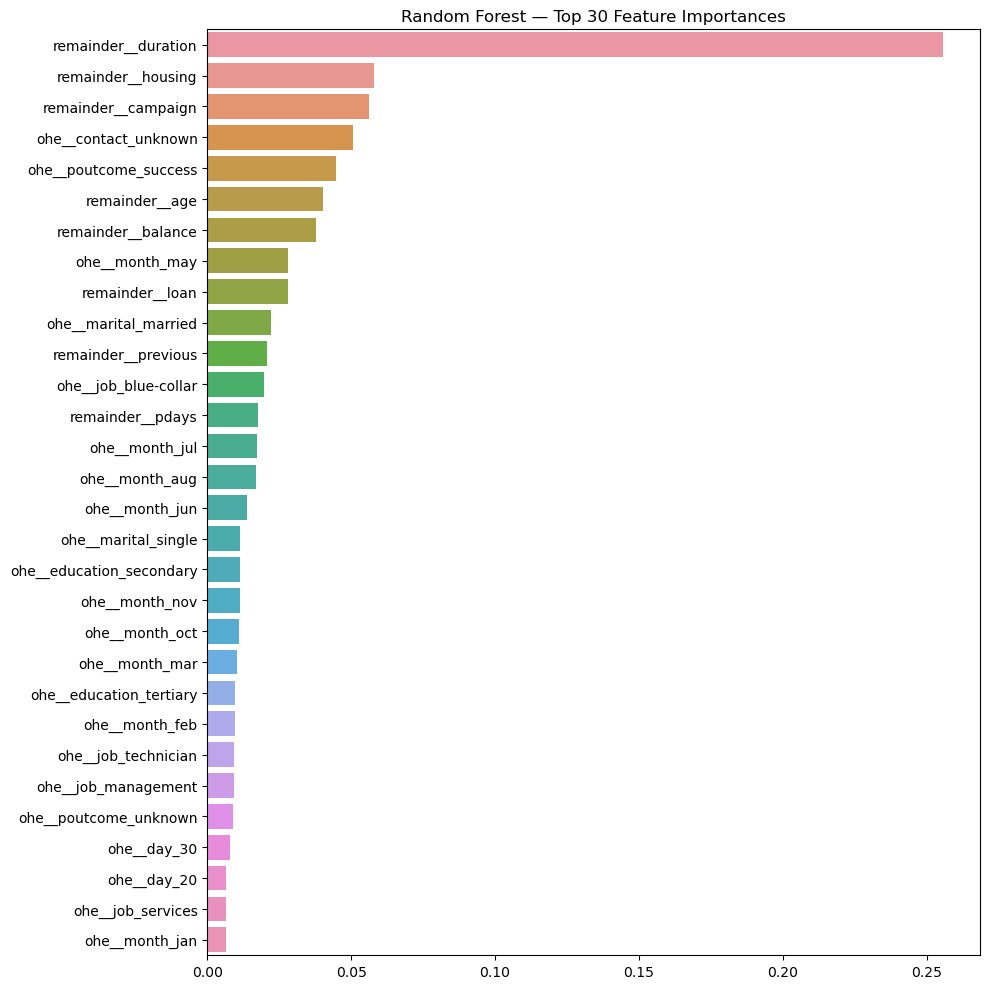


Top 10 RF features:
 remainder__duration      0.255809
remainder__housing       0.058000
remainder__campaign      0.056267
ohe__contact_unknown     0.050557
ohe__poutcome_success    0.044757
remainder__age           0.040107
remainder__balance       0.037736
ohe__month_may           0.028167
remainder__loan          0.028144
ohe__marital_married     0.021982
dtype: float64


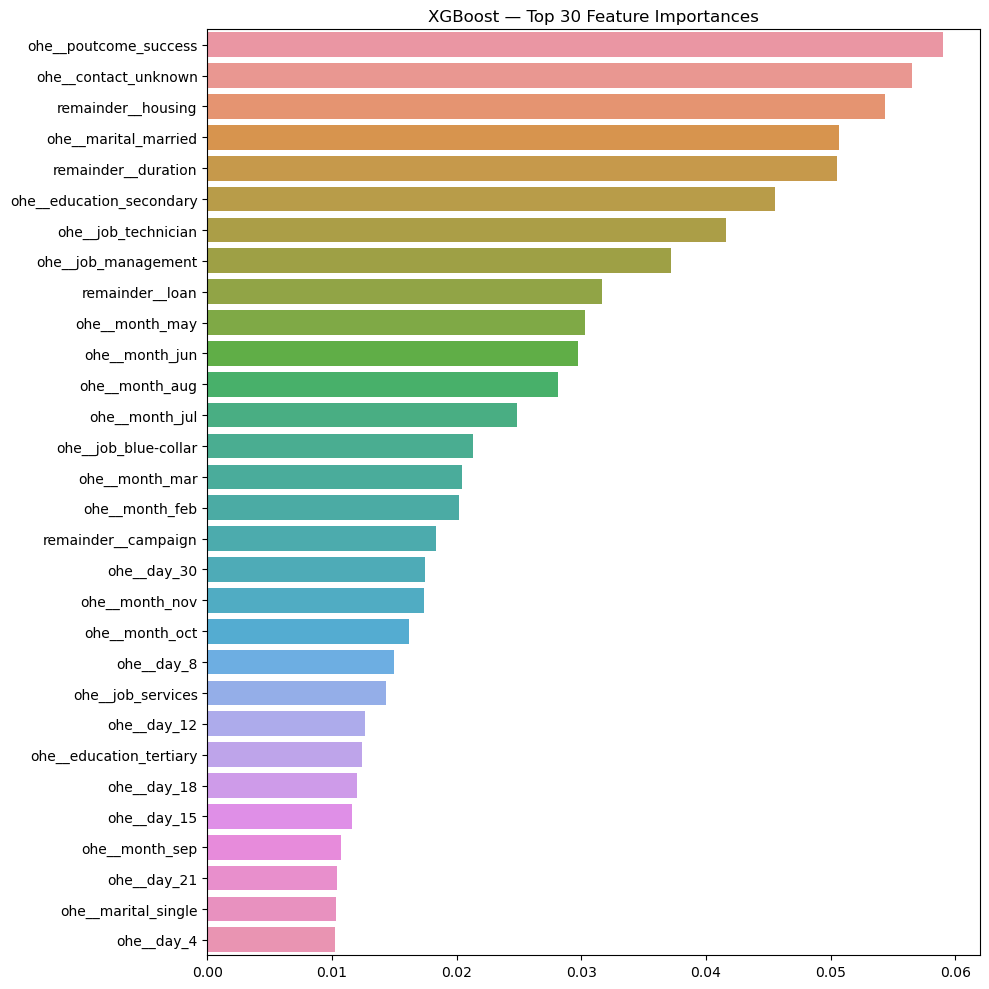


Top 10 XGB features:
 ohe__poutcome_success       0.059032
ohe__contact_unknown        0.056504
remainder__housing          0.054332
ohe__marital_married        0.050651
remainder__duration         0.050524
ohe__education_secondary    0.045569
ohe__job_technician         0.041581
ohe__job_management         0.037170
remainder__loan             0.031660
ohe__month_may              0.030305
dtype: float32


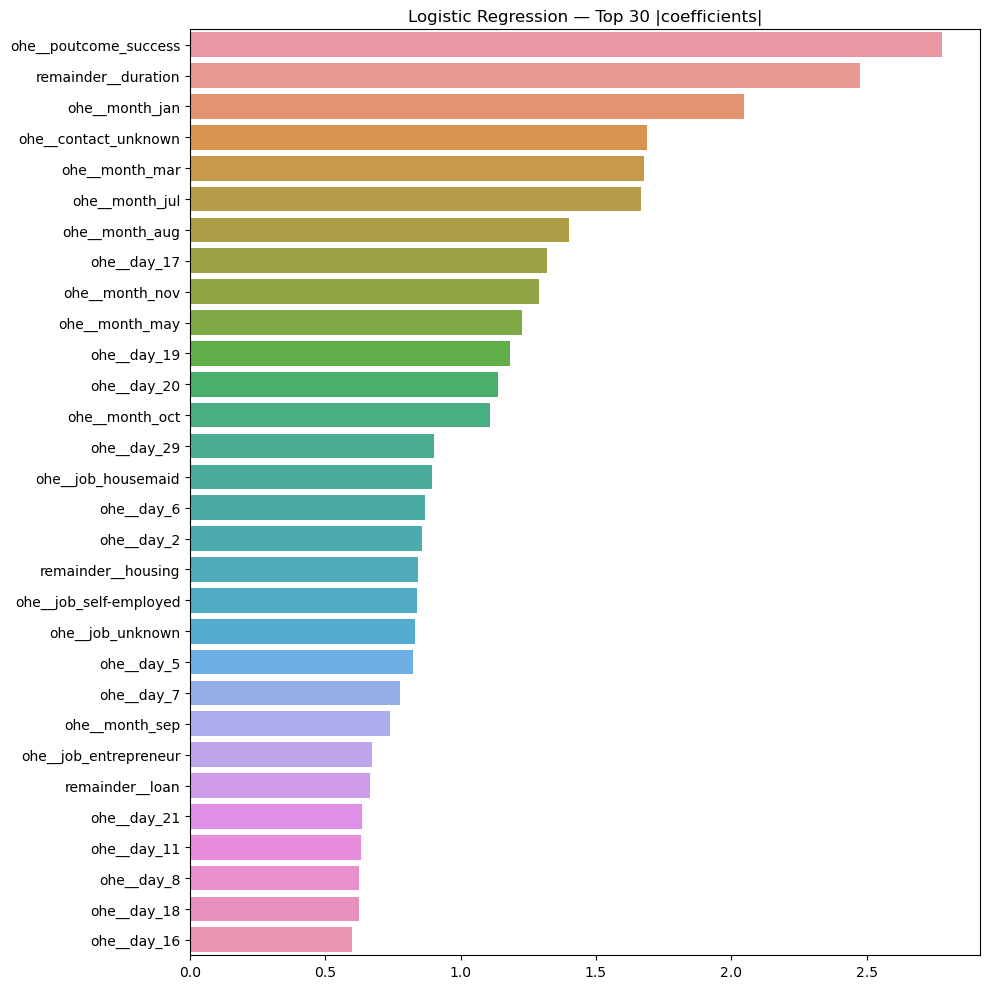


Top 10 Logistic Regression features:
 ohe__poutcome_success    2.780057
remainder__duration      2.477172
ohe__month_jan           2.047560
ohe__contact_unknown     1.689111
ohe__month_mar           1.677683
ohe__month_jul           1.668120
ohe__month_aug           1.402064
ohe__day_17              1.320239
ohe__month_nov           1.290713
ohe__month_may           1.226678
dtype: float64


In [37]:
def get_feature_names_ct(ct, input_features):
    try:
        return list(ct.get_feature_names_out())
    except:
        pass

    feature_names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'passthrough':
            if isinstance(cols, slice):
                cols = input_features[cols]
            feature_names.extend(cols)
        elif hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(list(trans.get_feature_names_out(cols)))
        else:
            if isinstance(cols, slice):
                cols = input_features[cols]
            feature_names.extend(cols)
    return feature_names

feature_names = get_feature_names_ct(ct, list(X.columns))

print("Количество признаков после OHE:", len(feature_names))

# Feature importance for Random Forest
rf = models["Random Forest"]

rf_importances = pd.Series(
    rf.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=rf_importances.values[:30], y=rf_importances.index[:30])
plt.title("Random Forest — Top 30 Feature Importances")
plt.tight_layout()
plt.show()

rf_importances.to_csv("feature_importance_random_forest.csv")
print("\nTop 10 RF features:\n", rf_importances.head(10))

# Feature importance for XGBoost
xgb = models["XGBoost"]

xgb_importances = pd.Series(
    xgb.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=xgb_importances.values[:30], y=xgb_importances.index[:30])
plt.title("XGBoost — Top 30 Feature Importances")
plt.tight_layout()
plt.show()

xgb_importances.to_csv("feature_importance_xgboost.csv")
print("\nTop 10 XGB features:\n", xgb_importances.head(10))

# Feature importance для Logistic Regression (abs(coef))
logreg = models["Logistic Regression"]

log_coef = pd.Series(
    np.abs(logreg.coef_[0]),
    index=feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=log_coef.values[:30], y=log_coef.index[:30])
plt.title("Logistic Regression — Top 30 |coefficients|")
plt.tight_layout()
plt.show()

log_coef.to_csv("feature_importance_logreg.csv")
print("\nTop 10 Logistic Regression features:\n", log_coef.head(10))

My goal is to achieve as better metrics as possible.
I focus on recall as it determines the whole number of target-clients.
To do this I will use threshhold tuning

#### SMOTE + Threshhold tuning


Training: Logistic Regression

Training: Random Forest

Training: XGBoost

=== Best threshholds for Recall ===
                  Model  Threshold  Precision    Recall        F1
0   Logistic Regression        0.1   0.216374  0.979206  0.354430
17        Random Forest        0.1   0.332567  0.957467  0.493665
34              XGBoost        0.1   0.375294  0.904537  0.530488

=== Best threshholds for F1 ===
                  Model  Threshold  Precision    Recall        F1
12  Logistic Regression       0.70   0.501027  0.691871  0.581183
21        Random Forest       0.30   0.503327  0.786389  0.613796
39              XGBoost       0.35   0.575243  0.672023  0.619878


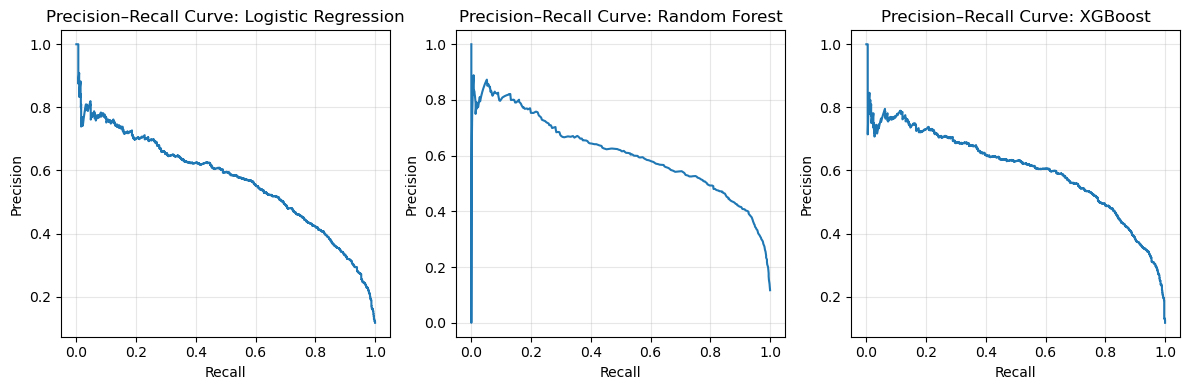

In [38]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# models training
trained_models = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train_sm, y_train_sm)
    trained_models[name] = model


# quality rate for THRESHOLD TUNING ----

thresholds = np.arange(0.1, 0.91, 0.05)
all_threshold_results = []

for name, model in trained_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)

        all_threshold_results.append({
            "Model": name,
            "Threshold": round(t, 3),
            "Precision": precision_score(y_test, y_pred_t),
            "Recall": recall_score(y_test, y_pred_t),
            "F1": f1_score(y_test, y_pred_t)
        })

df_thresholds = pd.DataFrame(all_threshold_results)


# best threshhold for recall 
best_recall = df_thresholds.loc[df_thresholds.groupby("Model")["Recall"].idxmax()]

# best threshhold for F1 
best_f1 = df_thresholds.loc[df_thresholds.groupby("Model")["F1"].idxmax()]

print("\n=== Best threshholds for Recall ===")
print(best_recall)

print("\n=== Best threshholds for F1 ===")
print(best_f1)


# Precision–Recall Curve
plt.figure(figsize=(12, 4))

for i, (name, model) in enumerate(trained_models.items()):
    plt.subplot(1, 3, i+1)

    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.plot(recall, precision)
    plt.title(f"Precision–Recall Curve: {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Final best result

**XGBoost with:**
- threshold = 0.35  
- precision = 0.57  
- recall = 0.67  
- f1-score = 0.62  

The goal is to find as many clients as possible who will agree to a deposit.

A threshold of **0.1** yields **Recall > 0.95**, but **Precision drops to 0.21–0.37**, meaning **70–80% of calls are wasted**.  
This is bad for the call center → too many unnecessary calls → increased costs.

**Two factors are important for bank deposit campaigns:**
1) not missing a client who might agree (**Recall**)  
2) not wasting budget and time on “empty” calls (**Precision**)  

# Conclusion

## EDA part

####  **Data Quality & Preprocessing**
- Missing categories such as *job*, *education*, and *contact* were kept as “unknown” because they reflect true absence of information rather than meaningful groups.  
- `pdays = -1` was reinterpreted as *no previous contact* → a new binary feature `no_prev_contact` was created, and `pdays` itself was cleaned by replacing `-1` with `0`.
- Core preprocessing included distribution analysis, outlier detection, winsorization, and selective log-transformations.

#### **Categorical Insights**
- **Job:** retirees and students subscribed at much higher rates.
- **Marital status:** married people dominate the dataset, but singles subscribe more frequently.
- **Education:** tertiary education correlates with higher subscription rate.
- **Loans:** people without personal/housing loans subscribe more often.
- **Contact type:** cellular communication strongly dominates and relates to higher success rates.
- **Month:** May has the greatest volume of contacts, but success rates peak in **September, October, March, December**.
- **Previous marketing outcome:** although mostly “unknown,” the *relative* share of successes is high.

#### **Correlation Structure**
- Mostly **weak positive correlations** (0–0.25) across features.
- Strongest relationships:
  - `pdays ↔ previous` (≈0.3)
  - `no_prev_contact ↔ pdays` (strong negative)
  - `no_prev_contact ↔ previous` (negative)
- Overall, correlations are low → low multicollinearity risk.

### Outlier Analysis

**Outlier percentages (IQR-based):**
- **High:** pdays, previous, no_prev_contact, balance, duration, campaign  
- **Low:** age  
- **None:** day

Because many features represent customer activity counts, outliers were preserved and treated with:
- **Winsorization** (IQR limits for each numerical column)
- **Log-transform** (only for strictly positive features)

This helped stabilize distributions without losing data, which is important for marketing/financial datasets.

#### **Final EDA Conclusion**
The dataset shows strong skewness, heavy-tailed financial-like distributions, and several categorical variables that meaningfully differentiate subscribers from non-subscribers. Correlations are mostly weak, indicating that each feature provides unique information. After applying IQR-based winsorization, selective log transforms, and careful handling of missing categories, the dataset is clean, well-structured, and ready for machine learning.  


## ML part

### **Modeling Setup**
- Binary target (`y`): *yes → 1*, *no → 0*.  
- Encoding:
  - `LabelEncoder` for binary columns (`default`, `housing`, `loan`).
  - One-hot encoding for multi-class categorical features.
- Models evaluated:
  - **Logistic Regression** — interpretable baseline capturing linear structure.
  - **Random Forest** — robust ensemble capturing nonlinear interactions.
  - **XGBoost** — gradient boosting optimized for tabular data, typically strongest for imbalanced + complex datasets.

### **Baseline Performance Comparison**
| Model | Accuracy | Precision | Recall | F1 | ROC-AUC |
|-------|----------|-----------|--------|-----|----------|
| Logistic Regression | 0.834 | 0.400 | 0.831 | 0.540 | 0.907 |
| Random Forest | 0.905 | 0.625 | 0.478 | 0.542 | 0.929 |
| **XGBoost** | **0.905** | **0.633** | **0.456** | **0.530** | **0.928** |

**Key observation:** Logistic Regression achieves high Recall but low Precision; tree-based models provide a more balanced trade-off. XGBoost and Random Forest deliver the highest ROC-AUC.

### **Threshold Optimization**
Two strategic criteria were evaluated:

#### **1. Maximizing Recall (finding as many potential clients as possible)**  
At threshold = 0.1:
- Recall > 0.90 for all models  
- Precision drops to 0.21–0.37  
- → leads to **70–80% wasted calls** → operationally unacceptable.

#### **2. Maximizing F1 (balance between Recall & Precision)**
| Model | Threshold | Precision | Recall | F1 |
|-------|-----------|-----------|--------|-----|
| Logistic Regression | 0.70 | 0.50 | 0.69 | 0.58 |
| Random Forest | 0.30 | 0.50 | 0.79 | 0.61 |
| **XGBoost** | **0.35** | **0.575** | **0.672** | **0.620** |

**XGBoost provides the highest F1-score**, meaning it achieves the best balance between not missing clients and avoiding wasted calls.

### **Final Model Choice: XGBoost (threshold = 0.35)**

- **Precision = 0.575**  
  → more than half of contacted clients are genuinely likely to open a deposit.

- **Recall = 0.672**  
  → the model captures ~67% of all potential subscribers, minimizing lost customers.

- **F1 = 0.619**  
  → best overall trade-off across all tested models.

- **ROC-AUC ≈ 0.93**  
  → excellent ability to separate interested vs. uninterested clients.

**Why this threshold?**  
It optimizes marketing ROI:  
- High Recall → we do not miss valuable leads.  
- Adequate Precision → we avoid calling too many uninterested customers.  
- Best balance for a real call-center campaign.

## Feature Interpretation

### **Top Feature Contributors per Model**

#### **XGBoost (most powerful model)**
1. `poutcome_success`  
2. `contact_unknown`  
3. `housing`  
4. `marital_married`  
5. `duration`  
6. `education_secondary`  
7. `job_technician`  
8. `job_management`  
9. `loan`  
10. `month_may`

**Interpretation:**  
- Outcome of previous marketing campaigns is the strongest differentiator.  
- Contact method plays a key role (“unknown” contact suggests special handling).  
- Marital status, job, and loan status significantly affect deposit willingness.  
- Call duration remains one of the most powerful predictors across all models.

---

#### **Random Forest**
1. `duration`  
2. `housing`  
3. `campaign`  
4. `contact_unknown`  
5. `poutcome_success`  
6. `age`  
7. `balance`  
8. `month_may`  
9. `loan`  
10. `marital_married`

**RF highlights importance of:**

- call duration  
- campaign intensity  
- client financial situation (balance, housing/loan)  

---

#### **Logistic Regression**
Top positive coefficients:
1. `poutcome_success`  
2. `duration`  
3. `month_jan`  
4. `contact_unknown`  
5. `month_mar`, `month_jul`, `month_aug`
6. `day_17`

LR confirms:

- success in previous campaigns → strong signal,
- duration → consistently predictive,
- several months show elevated likelihood due to seasonal behavior.
  

### **Final Interpretation**
- All models consistently identify **duration** and **previous marketing success** as the most important predictors of subscription.
- Financial indicators (`balance`, `loan`, `housing`) matter but are secondary.
- Categorical marketing attributes (`month`, `contact`, `poutcome`) play a significant strategic role.
- XGBoost’s feature importance aligns with domain intuition: previous engagement and communication method are critical for marketing response.

---

### **Final Conclusion**
The optimal solution is **XGBoost with threshold = 0.35**, providing the best balance between business efficiency (Precision) and customer coverage (Recall). The model is well-interpretable through feature importance, stable across metrics, and aligns with expected marketing behaviors. This makes it the best candidate for deployment in a bank deposit campaign.


# Limitation of the analysis

### **1. Dataset Structure and Bias**
- The data originates from a single bank's marketing campaign, which may introduce **sampling bias** and limit generalizability to other institutions or regions.
- Some categorical groups (e.g., `poutcome=success`) are strongly imbalanced, which may cause the model to over-emphasize rare patterns.

### **2. Target Leakage Risk**
- The feature `duration` is known to indirectly contain **post-call information**, meaning it may not be available at prediction time in real campaigns.  
  Although retained for modeling purposes, real-world deployment would require removing or separately evaluating this feature.

### **3. Outliers and Transformation Constraints**
- Several features (e.g., `pdays`, `previous`, `balance`) contain extreme values and heavy skewness.  
- Not all transformations were applicable (e.g., log transform cannot be applied to negative balances or zeros), which limited normalization quality.
- Winsorization reduces outlier influence but may distort genuine high-value behavior.

### **4. Encoding and Feature Engineering**
- Only standard encoding techniques (OHE, LabelEncoder) were used.  
  More advanced approaches (target encoding, embeddings) could extract richer information.
- Interaction features were not engineered; tree models partly capture interactions but linear models remain limited.

### **5. Threshold Selection Dependency**
- The chosen threshold (0.35 for XGBoost) is optimized for this specific test split.  
  In production, threshold stability should be validated across multiple time periods or via cross-validation.

### **6. Limited Model Variety**
- Only three models were evaluated.  
  Algorithms like CatBoost or LightGBM, which excel on categorical data, were not included and may outperform the current models.


# Future work and recommendations

### **1. Improve Feature Engineering**
- Create domain-specific interaction features (e.g., `campaign × previous`, `balance / age`, `loan & housing combination`).
- Explore advanced encoding:
  - **Target encoding**
  - **CatBoost encoding**
  - **Learned embeddings** for high-cardinality categories.

### **2. Handle Duration More Robustly**
- Build a separate model **without `duration`** to simulate real-time call prediction.  
- Compare performance to ensure no target leakage influences decision-making.

### **3. Use More Advanced Models**
- Experiment with:
  - **LightGBM** (faster & often more accurate than XGBoost),
  - **CatBoost** (especially suited for categorical-heavy data),
  - **Logistic Regression with polynomial or interaction terms**.

### **4. Hyperparameter Optimization**
- Apply systematic optimization (Optuna, Bayesian search).  
- Tune:
  - tree depth,  
  - learning rate,  
  - number of estimators,  
  - class weight balancing.

### **5. Time-Aware Validation**
- Evaluate models using **time-series split** instead of random train-test split, since marketing data is temporal.
- Ensures model performance remains stable across different campaign months.

### **6. Cost-Sensitive Learning**
- Build a custom objective reflecting:
  - cost of unnecessary calls,
  - value of successfully converted clients.

This approach can directly optimize business ROI rather than purely statistical metrics.

### **7. Explainability & Monitoring**
- Use SHAP-based interpretability for deeper understanding of client behavior.
- Track:
  - drift in distribution (balance, age, campaign),
  - model’s Precision/Recall over time,
  - operational metrics (calls saved, conversions captured).

### **8. Deploy and Integrate with Business Workflow**
- Implement model in marketing workflow:
  - rank customers by probability,
  - limit daily calls based on available resources,
  - dynamically adjust threshold based on campaign goals.